Analysis of HEK Lineage Tracing experiment 4/3/2019

In [1]:
import numpy as np
import scanpy.api as sc
import os
import scanpy
import re
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=70)  # dots (pixels) per inch determine size of inline figures
sc.settings.cachedir='/home/mt/Downloads/HEKlineage/'
sc.logging.print_versions()
#spec = importlib.util.spec_from_file_location("ScanpyUtilsMT", os.path.expanduser("~/code/MTsc/utils/ScanpyUtilsMT.py"))
#sc_utils = importlib.util.module_from_spec(spec)
#spec.loader.exec_module(sc_utils)



scanpy==1.4 anndata==0.6.19 numpy==1.16.2 scipy==1.2.1 pandas==0.24.2 scikit-learn==0.20.3 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


In [2]:
well1data = sc.read_10x_mtx('/home/mt/Downloads/well1_Out/outs/filtered_feature_bc_matrix/',cache=True)

adata=well1data
adata.var_names_make_unique()  # this is unnecessary if using 'gene_ids'

... reading from cache file /home/mt/Downloads/HEKlineage/home-mt-Downloads-well1_Out-outs-filtered_feature_bc_matrix-matrix.h5ad


Run standard preprocessing steps, see [here](https://scanpy.readthedocs.io/en/latest/api/scanpy.api.pp.recipe_zheng17.html#scanpy.api.pp.recipe_zheng17).

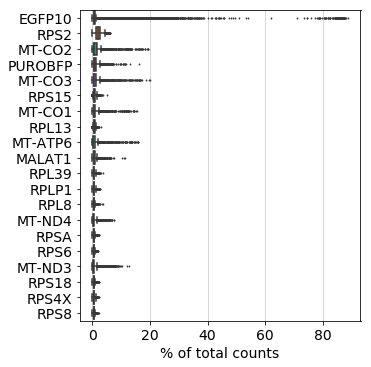

filtered out 15 cells that have less than 30 genes expressed
filtered out 12909 genes that are detected in less than 3 cells


... storing 'feature_types' as categorical


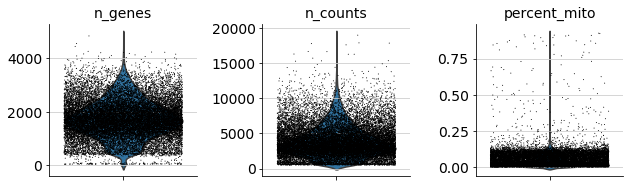

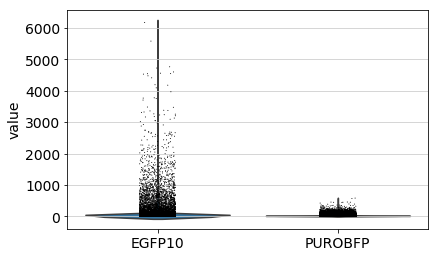

--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [3]:
sc.pl.highest_expr_genes(adata, n_top=20)
n_top_genes=5000
log=False
sc.pp.filter_cells(adata, min_genes=30)
sc.pp.filter_genes(adata, min_cells=3)


mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)
sc.pl.violin(adata, ['EGFP10','PUROBFP'])

adata = adata[adata.obs['n_genes'] > 500, :]
adata = adata[adata.obs['percent_mito'] < 0.5, :]

sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

sc.pp.log1p(adata)

adata.raw = adata

sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata.var['highly_variable'][[x in ['EGFP10','EGFP18','EBNA1','PUROBFP'] for x in list(adata.var.index)]]=False
adata = adata[:, adata.var['highly_variable']]
sc.pp.scale(adata, max_value=10)


In [4]:
sc.tl.pca(adata)

Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.


In [5]:
sc.pp.neighbors(adata,metric='manhattan')

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:18.27) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix


In [6]:
sc.tl.umap(adata)

computing UMAP
    finished (0:00:29.67) --> added
    'X_umap', UMAP coordinates (adata.obsm)


In [7]:
sc.tl.leiden(adata)

running Leiden clustering
    finished (0:00:18.22) --> found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical)


<bound method AnnData.obs_keys of AnnData object with n_obs × n_vars = 19645 × 2117 
    obs: 'n_genes', 'percent_mito', 'n_counts', 'leiden'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'>


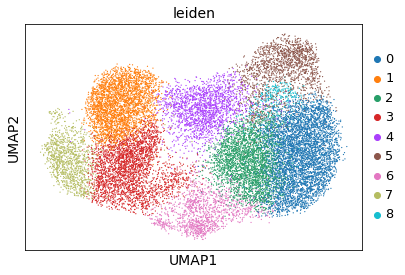

In [8]:
print(adata.obs_keys)
sc.pl.umap(adata, color='leiden')

In [9]:
import pandas as pd
labeltable=pd.read_csv("~/Downloads/well1_Out/outs/pCXLE18_calltable.txt",sep='\t',header = 0)
labeltable.index=labeltable['Cell']
if 'Label' in adata.obs.columns:
    adata.obs.drop('Label',axis=1,inplace=True)
adata.obs.insert(0,value=labeltable.loc[:,"Call"],column='Label')


In [10]:
adata

AnnData object with n_obs × n_vars = 19645 × 2117 
    obs: 'Label', 'n_genes', 'percent_mito', 'n_counts', 'leiden'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

... storing 'Label' as categorical


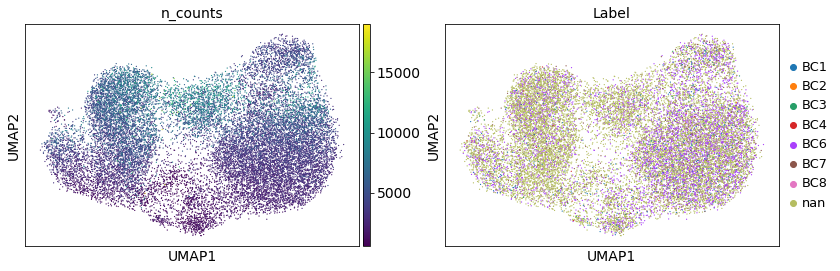

In [11]:
sc.pl.umap(adata, color=['n_counts','Label'])

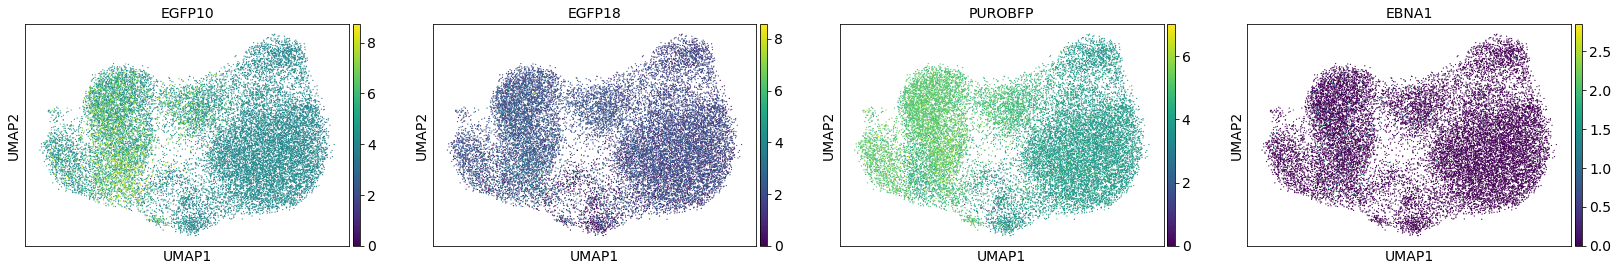

In [12]:
sc.pl.umap(adata, color=['EGFP10','EGFP18','PUROBFP','EBNA1'])

In [13]:
adata

AnnData object with n_obs × n_vars = 19645 × 2117 
    obs: 'Label', 'n_genes', 'percent_mito', 'n_counts', 'leiden'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors', 'leiden', 'leiden_colors', 'Label_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [14]:
def cell_cycle_score(adata,save=False):
    s_genes=['MCM5', 'PCNA', 'TYMS', 'FEN1', 'MCM2', 'MCM4', 'RRM1', 'UNG', 'GINS2', 'MCM6', 'CDCA7', 'DTL', 'PRIM1', 'UHRF1', 'MLF1IP', 'HELLS', 'RFC2', 'RPA2', 'NASP', 'RAD51AP1', 'GMNN', 'WDR76', 'SLBP', 'CCNE2', 'UBR7', 'POLD3', 'MSH2', 'ATAD2', 'RAD51', 'RRM2', 'CDC45', 'CDC6', 'EXO1', 'TIPIN', 'DSCC1', 'BLM', 'CASP8AP2', 'USP1', 'CLSPN', 'POLA1', 'CHAF1B', 'BRIP1', 'E2F8']
    g2m_genes=['HMGB2', 'CDK1', 'NUSAP1', 'UBE2C', 'BIRC5', 'TPX2', 'TOP2A', 'NDC80', 'CKS2', 'NUF2', 'CKS1B', 'MKI67', 'TMPO', 'CENPF', 'TACC3', 'FAM64A', 'SMC4', 'CCNB2', 'CKAP2L', 'CKAP2', 'AURKB', 'BUB1', 'KIF11', 'ANP32E', 'TUBB4B', 'GTSE1', 'KIF20B', 'HJURP', 'CDCA3', 'HN1', 'CDC20', 'TTK', 'CDC25C', 'KIF2C', 'RANGAP1', 'NCAPD2', 'DLGAP5', 'CDCA2', 'CDCA8', 'ECT2', 'KIF23', 'HMMR', 'AURKA', 'PSRC1', 'ANLN', 'LBR', 'CKAP5', 'CENPE', 'CTCF', 'NEK2', 'G2E3', 'GAS2L3', 'CBX5', 'CENPA']
    sc.tl.score_genes_cell_cycle(adata,s_genes=s_genes,g2m_genes=g2m_genes)
    sc.pl.violin(adata, ['G2M_score','S_score'], groupby='leiden')
    if 'X_tsne' in adata.obsm.keys(): 
        sc.pl.tsne(adata, color=['G2M_score','S_score','phase','leiden'],save='_cc')
    sc.pl.umap(adata, color=['G2M_score','S_score','phase','leiden'],save='_cc')
    return(adata)

In [15]:
def bcTableToAnndata(bctabPath,correctionPath=None,binary=True,threshold=0):
    import pandas as pd
    bctable=pd.read_csv(bctabPath,sep='\t',header = 0)
    if correctionPath is not None:
        correcttable=pd.read_csv(correctionPath,sep='\t',header = None,index_col=False)
        newtab=[]
        for index,cluster in correcttable.iterrows():
            ll=[int(x) for x in cluster[2].split(',')]
            newtab.append(pd.DataFrame({'Cell.BC':bctable['Cell.BC'][ll],'Cell.Tag':np.repeat(cluster[0],len(ll))}))
        bctable=pd.concat(newtab)
    import anndata
    import scipy
    bctable=pd.DataFrame(bctable.groupby(['Cell.BC','Cell.Tag']).size().reset_index().rename(columns={0:'count'}))
    bctable=bctable.loc[bctable['count']>threshold,:]
    #bctable=bctable.drop('UMI',axis=1)
    print(len(bctable['Cell.Tag'].unique()))
    bcfac=pd.factorize(bctable['Cell.BC'],sort=True)
    tagfac=pd.factorize(bctable['Cell.Tag'],sort=True)
    bctable['Cell.BC']=bcfac[0]
    bctable['Cell.Tag']=tagfac[0]
    if binary:
        bctable['count']=1        
    bcann=anndata.AnnData(scipy.sparse.csc_matrix((list(bctable['count']),(list(bctable['Cell.BC']),list(bctable['Cell.Tag']))),shape=(len(bcfac[1]), len(tagfac[1]))))
    print(bcann)
    bcann.obs.index=bcfac[1]
    bcann.var.index=tagfac[1]
    return(bcann)
    

In [16]:
bcann=bcTableToAnndata("~/Downloads/well1_Out/outs/pCXLE10_bctable.txt",correctionPath="/home/mt/Downloads/well1_Out/outs/collapsed_pCXLE10_bctable.txt",threshold=0)

/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/pandas/core/series.py:942: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


1149
AnnData object with n_obs × n_vars = 20357 × 1149 


In [17]:
bcann=bcann[np.argsort(list(-np.sum(bcann.X,axis=1)),axis=None),:]
bcann=bcann[:,np.argsort(list(-np.sum(bcann.X,axis=0)),axis=None)]
print(bcann)

View of AnnData object with n_obs × n_vars = 20357 × 1149 


In [18]:
ctann=bcTableToAnndata("~/Downloads/well1_Out/outs/pU6_bctable.txt","~/Downloads/well1_Out/outs/collapsed_pU6_bctable.txt",threshold=0)
ctann=ctann[np.argsort(list(-np.sum(ctann.X,axis=1)),axis=None),:]
ctann=ctann[:,np.argsort(list(-np.sum(ctann.X,axis=0)),axis=None)]

208
AnnData object with n_obs × n_vars = 19882 × 208 


In [19]:
labelann=bcTableToAnndata("/home/mt/Downloads/well1_Out/outs/pCXLE18_bcs.txt","/home/mt/Downloads/well1_Out/outs/collapsed_pCXLE18_bcs.txt",threshold=0,binary=False)
labelann=labelann[np.argsort(list(-np.sum(labelann.X,axis=1)),axis=None),:]
labelann=labelann[:,np.argsort(list(-np.sum(labelann.X,axis=0)),axis=None)]
labelann.var['count']=np.sum(labelann.X,axis=0).A1
labelann=labelann[:,0:8]
labelann=labelann[np.sum(labelann.X,axis=1).A1>0,:]

664
AnnData object with n_obs × n_vars = 17553 × 664 


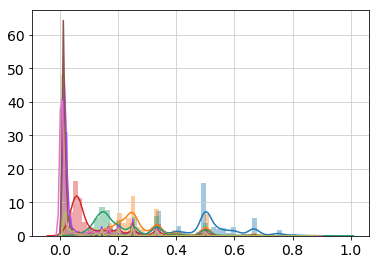

In [20]:
import seaborn
adjustedlabels=labelann.X/(np.sum(labelann.X,axis=1)+1)
for i in range(adjustedlabels.shape[1]):
    seaborn.distplot(adjustedlabels[np.array((adjustedlabels[:,i]>0)).flatten(),i])


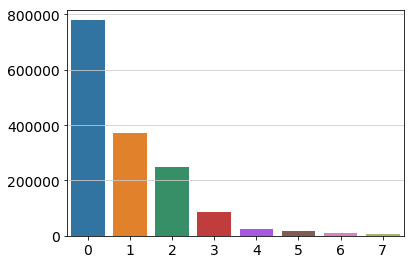

In [21]:
seaborn.barplot(x=list(range(8)),y=np.array(np.sum(labelann.X,axis=0)).flatten())

In [22]:
argmaxes=np.argmax(adjustedlabels,axis=1)
maxes=np.max(adjustedlabels,axis=1)
from collections import Counter
print(Counter([argmaxes[i].item() if maxes[i] >.7 else 'Doublet' for i in range(len(maxes))]))
labelann.obs['Label']=[argmaxes[i].item() if maxes[i] >.66 else 'Doublet' for i in range(len(maxes))]

Counter({'Doublet': 16731, 0: 775, 2: 21, 1: 20, 6: 3, 7: 1, 3: 1})


In [23]:
labelann.obs['MaxProportion']=np.max(adjustedlabels,axis=1)

In [24]:
if 'MaxProportion' in adata.obs.columns:
    adata.obs.drop('MaxProportion',axis=1,inplace=True)
adata.obs.insert(0,value=labelann.obs["MaxProportion"],column='MaxProportion')

In [25]:
if 'Label2' in adata.obs.columns:
    adata.obs.drop('Label2',axis=1,inplace=True)
adata.obs.insert(0,value=labelann.obs["Label"],column='Label2')

(20357, 1)


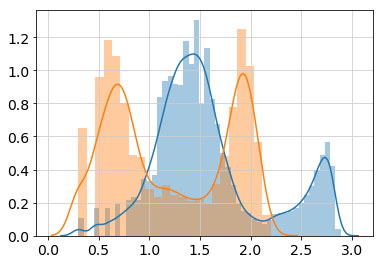

In [26]:
#plasmids per cell
import seaborn
print(np.sum(bcann.X,axis=1).shape)
seaborn.distplot(np.log10(np.sum(bcann.X,axis=1)+1))
seaborn.distplot(np.log10(np.sum(ctann.X,axis=1)+1))

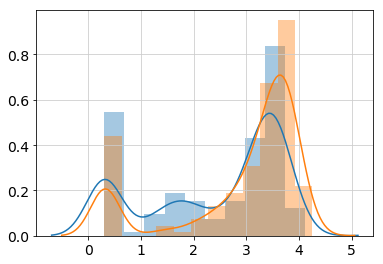

In [27]:
#Cells per plasmid
seaborn.distplot(np.log10(np.sum(bcann.X,axis=0)+1))
seaborn.distplot(np.log10(np.sum(ctann.X,axis=0)+1))

In [28]:
bcann.obs['n_barcodes']=np.log10(np.sum(bcann.X,axis=1)+1)
sc.pp.filter_genes(bcann, min_cells=3)
sc.pp.filter_genes(bcann, max_cells=bcann.shape[0]/2)
bcann=bcann[bcann.obs['n_barcodes']<=2.1,:]
sc.tl.pca(bcann)
sc.pp.neighbors(bcann,metric='manhattan')
sc.tl.umap(bcann)
sc.tl.leiden(bcann)
bcann

filtered out 238 genes that are detected in less than 3 cells
filtered out 3 genes that are detected in more than  10178.5 cells
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:08.66) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:20.72) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Leiden clustering
    finished (0:00:11.45) --> found 24 clusters and added
    'leiden', the cluster labels (adata.obs, categorical)


AnnData object with n_obs × n_vars = 16583 × 908 
    obs: 'n_barcodes', 'leiden'
    var: 'n_cells'
    uns: 'pca', 'neighbors', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [29]:
'''import sklearn.cluster
km=sklearn.cluster.MiniBatchKMeans(25,max_iter=1000,n_init=100,batch_size=10000,verbose=1)
km.fit(bcann.X)
print(km.predict(bcann.X))
bcann.obs['kmeans']=pd.Categorical( km.predict(bcann.X))'''

"import sklearn.cluster\nkm=sklearn.cluster.MiniBatchKMeans(25,max_iter=1000,n_init=100,batch_size=10000,verbose=1)\nkm.fit(bcann.X)\nprint(km.predict(bcann.X))\nbcann.obs['kmeans']=pd.Categorical( km.predict(bcann.X))"

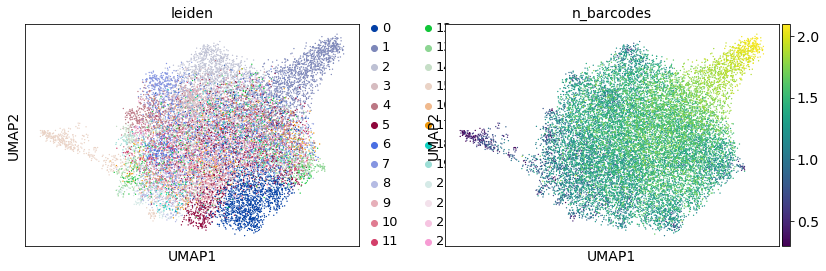

In [30]:
sc.pl.umap(bcann,color=['leiden','n_barcodes'])
if 'EpiClone' in adata.obs.columns:
    adata.obs.drop('EpiClone',axis=1,inplace=True)
adata.obs.insert(0,value=bcann.obs["leiden"],column='EpiClone')

In [31]:
ctann.obs['n_barcodes']=np.log10(np.sum(ctann.X,axis=1)+1)
ctann=ctann[ctann.obs['n_barcodes']<=1.5,:]
sc.pp.filter_genes(ctann, min_cells=3)
sc.pp.filter_genes(ctann, max_cells=ctann.shape[0]/2)
sc.pp.filter_cells(ctann, min_genes=2)

sc.tl.pca(ctann)
sc.pp.neighbors(ctann,metric='manhattan')
sc.tl.umap(ctann)
sc.tl.leiden(ctann)


filtered out 33 genes that are detected in less than 3 cells
filtered out 3 genes that are detected in more than  5968.5 cells
filtered out 4198 cells that have less than 2 genes expressed
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:04.97) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:28.86) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Leiden clustering
    finished (0:00:01.92) --> found 66 clusters and added
    'leiden', the cluster labels (adata.obs, categorical)


In [32]:
ctann

AnnData object with n_obs × n_vars = 7739 × 172 
    obs: 'n_barcodes', 'n_genes', 'leiden'
    var: 'n_cells'
    uns: 'pca', 'neighbors', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

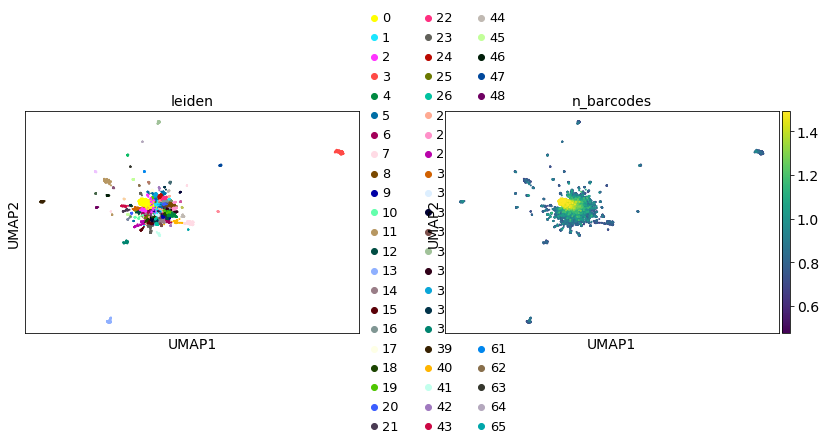

/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


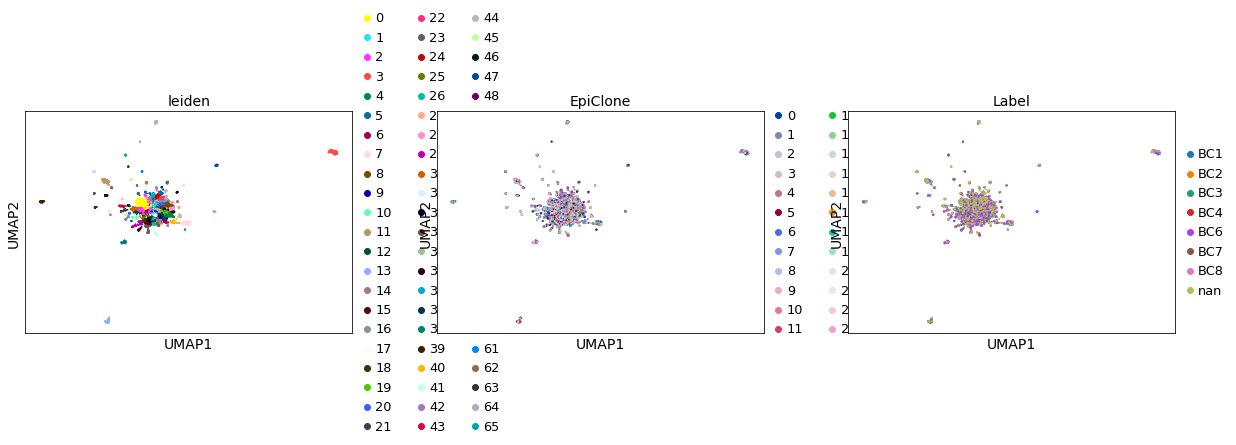

In [33]:
sc.pl.umap(ctann,color=['leiden','n_barcodes'])
adata.obs['LentiClone']=ctann.obs.loc[adata.obs.index,"leiden"]
if 'EpiClone' in ctann.obs.columns:
    ctann.obs.drop('EpiClone',axis=1,inplace=True)
ctann.obs.insert(0,value=bcann.obs["leiden"],column='EpiClone')
if 'Label' in ctann.obs.columns:
    ctann.obs.drop('Label',axis=1,inplace=True)
ctann.obs.insert(0,value=adata.obs["Label"],column='Label')

sc.pl.umap(ctann,color=['leiden','EpiClone','Label'])


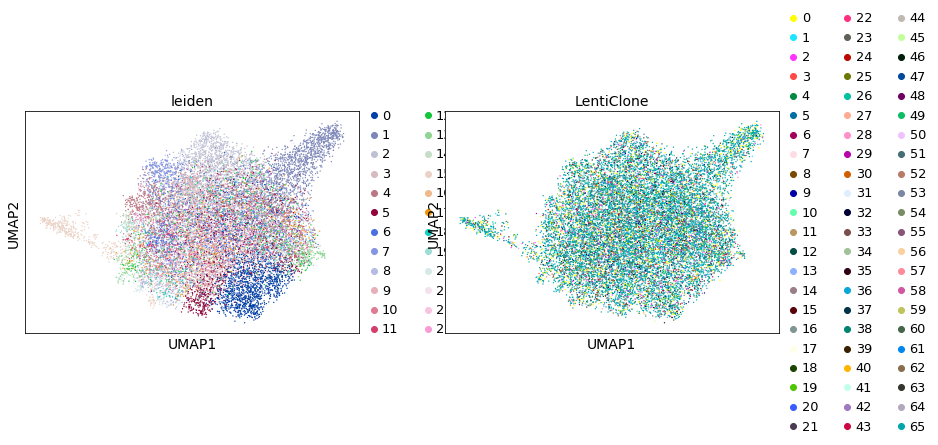

In [34]:
if 'LentiClone' in bcann.obs.columns:
    bcann.obs.drop('LentiClone',axis=1,inplace=True)
bcann.obs.insert(0,value=ctann.obs["leiden"],column='LentiClone')
sc.pl.umap(bcann,color=['leiden','LentiClone'])


In [35]:
print(ctann)
print(bcann)

AnnData object with n_obs × n_vars = 7739 × 172 
    obs: 'Label', 'EpiClone', 'n_barcodes', 'n_genes', 'leiden'
    var: 'n_cells'
    uns: 'pca', 'neighbors', 'leiden', 'leiden_colors', 'EpiClone_colors', 'Label_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
AnnData object with n_obs × n_vars = 16583 × 908 
    obs: 'LentiClone', 'n_barcodes', 'leiden'
    var: 'n_cells'
    uns: 'pca', 'neighbors', 'leiden', 'leiden_colors', 'LentiClone_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'


... storing 'Label2' as categorical


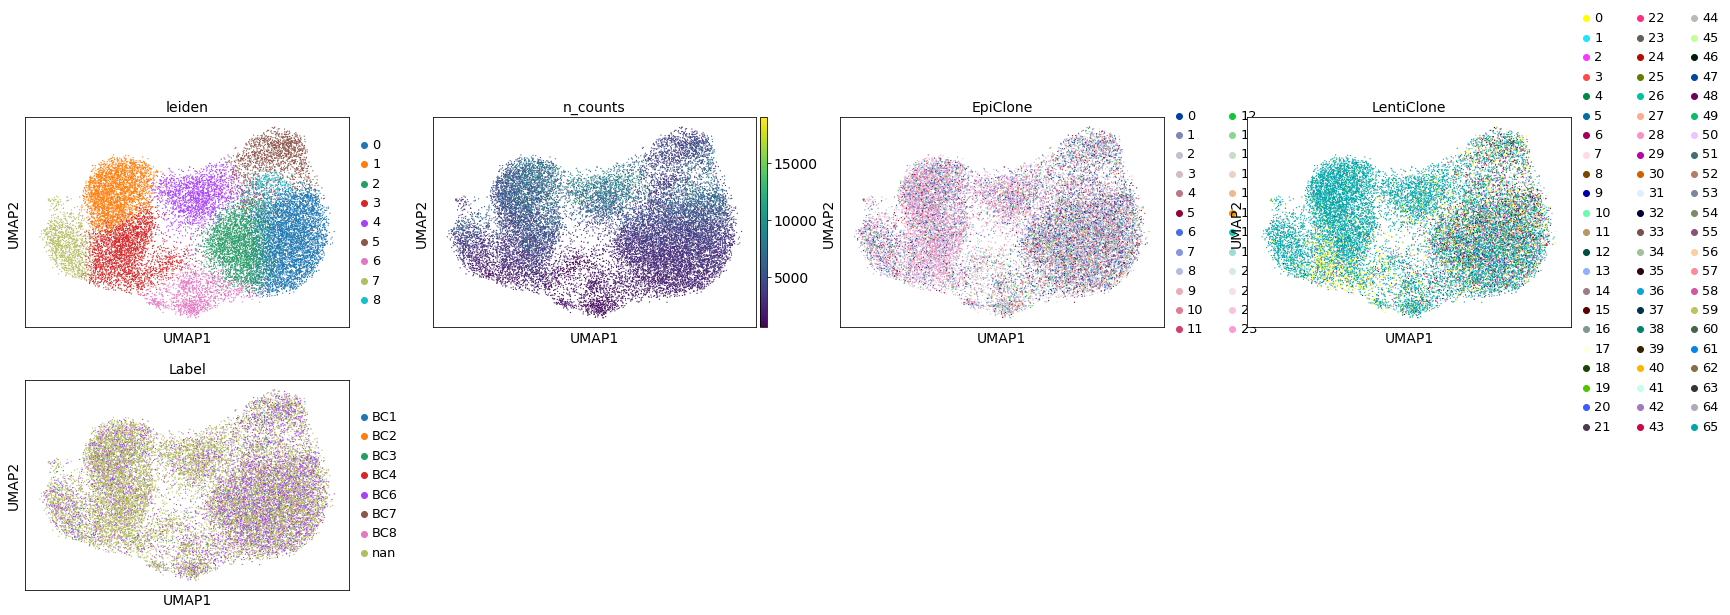

In [36]:
sc.pl.umap(adata,color=['leiden','n_counts','EpiClone','LentiClone','Label'])

In [37]:
if 'EpiNum' in adata.obs.columns:
    adata.obs.drop('EpiNum',axis=1,inplace=True)
adata.obs.insert(0,value=bcann.obs["n_barcodes"],column='EpiNum')

In [38]:
if 'LentiNum' in adata.obs.columns:
    adata.obs.drop('LentiNum',axis=1,inplace=True)
adata.obs.insert(0,value=ctann.obs["n_barcodes"],column='LentiNum')

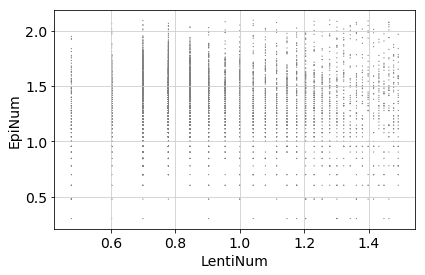

In [39]:
sc.plotting.scatter(adata,x='LentiNum',y='EpiNum')

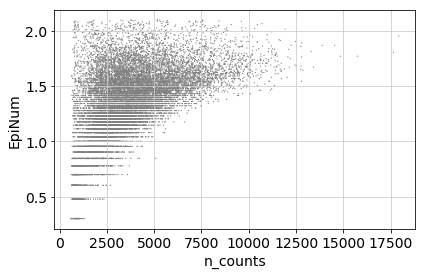

In [40]:
sc.plotting.scatter(adata,x='n_counts',y='EpiNum')

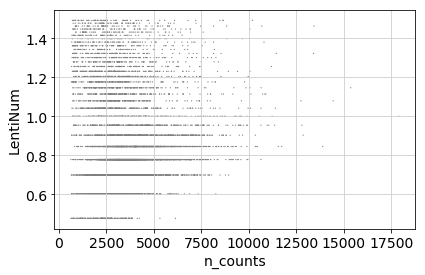

In [41]:
sc.plotting.scatter(adata,x='n_counts',y='LentiNum')

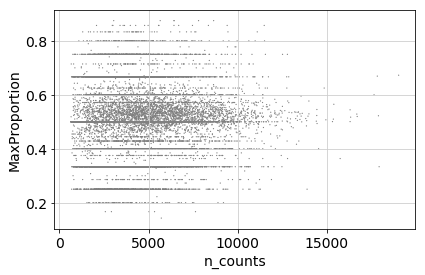

In [42]:
sc.plotting.scatter(adata,x='n_counts',y='MaxProportion')

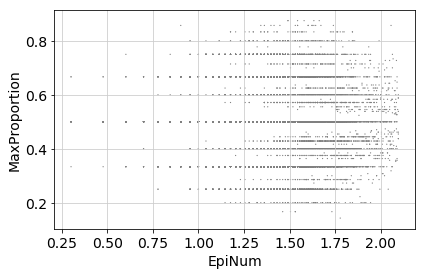

In [43]:
sc.plotting.scatter(adata,x='EpiNum',y='MaxProportion')

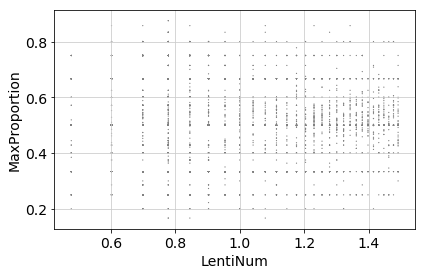

In [44]:
sc.plotting.scatter(adata,x='LentiNum',y='MaxProportion')

In [45]:
cells=list(set(adata.obs.index).intersection(set(bcann.obs.index),set(ctann.obs.index)))
len(cells)

6736

In [9]:
import numpy as np
import scanpy.api as sc
import os
import scanpy
import re
#adata.write('~/Downloads/adata.h5ad')
#bcann.write('~/Downloads/bcann.h5ad')
#ctann.write('~/Downloads/ctann.h5ad')
#labelann.write('~/Downloads/labelann.h5ad')
adata=sc.read_h5ad('~/Downloads/adata.h5ad')
bcann=sc.read_h5ad('~/Downloads/bcann.h5ad')
ctann=sc.read_h5ad('~/Downloads/ctann.h5ad')
labelann=sc.read_h5ad('~/Downloads/labelann.h5ad')



In [14]:
import networkx as nx
def jaccardMatrix(m):
    return(scipy.sparse.csr_matrix(m*m.T/((np.ones(m.shape)*m.T+m*np.ones(m.shape).T)-m*m.T)))

In [ ]:
cells=list(set(adata.obs.index).intersection(set(bcann.obs.index),set(ctann.obs.index)))
adata=adata[cells,:]
bcann=bcann[cells,:]
ctann=ctann[cells,:]
labelann=labelann[[x for x in labelann.obs.index if x in cells],:]

In [17]:
import random
import seaborn
#bcx=(bcann.X*bcann.X.T)
#ctx=(ctann.X*ctann.X.T)
bcx=jaccardMatrix(bcann.X)
ctx=jaccardMatrix(ctann.X)
scrambleinds=list(range(ctann.shape[0]))
random.shuffle(scrambleinds)
ctxscramble=(ctann[scrambleinds,:].X*ctann[scrambleinds,:].X.T)

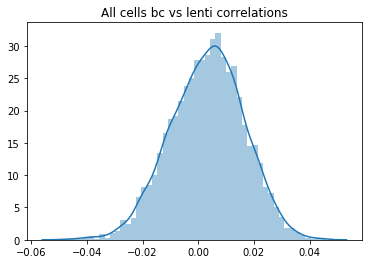

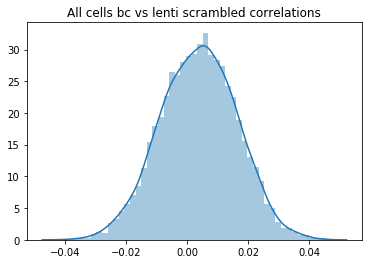

In [18]:
import matplotlib.pyplot as plt
import scipy
bcx=bcx.todense()
ctx=ctx.todense()
ctxscramble=ctxscramble.todense()

np.fill_diagonal(bcx,0)
np.fill_diagonal(ctx,0)

corrs=[]
for i in range(bcx.shape[0]):
    corrs.append(scipy.stats.spearmanr(bcx[i,:].T, ctx[i,:].T)[0])
corrs=np.array(corrs)
corrs=corrs[~np.isnan(corrs)]
seaborn.distplot(corrs,norm_hist=True)
plt.title('All cells bc vs lenti correlations')
plt.show()


np.fill_diagonal(ctxscramble,0)

randocorrs=[]
for i in range(bcx.shape[0]):
    randocorrs.append(scipy.stats.spearmanr(bcx[i,:].T, ctxscramble[i,:].T)[0])
randocorrs=np.array(randocorrs)
randocorrs=randocorrs[~np.isnan(randocorrs)]
seaborn.distplot(randocorrs,norm_hist=True)
plt.title('All cells bc vs lenti scrambled correlations')
plt.show()

In [ ]:
for cellbc in adata.obs['Label2'].unique():
    print(cellbc)
    adata6=adata[adata.obs['Label2']==cellbc,:]
    bcann6=bcann[[x for x in bcann.obs.index if x in adata6.obs.index],:]
    ctann6=ctann[[x for x in ctann.obs.index if x in adata6.obs.index],:]
    print(adata6)
    print(bcann6)
    print(ctann6)
    if ctann.shape[0]>0:
        seaborn.clustermap(bcann6.X.todense()[0:3500,0:3500])
        plt.show()
        seaborn.clustermap(ctann6.X.todense()[0:3500,0:3500])
        plt.show()
        m = bcann6.X * bcann6.X.T
        seaborn.clustermap(np.log10(m.todense()+1))
        plt.show()
        m=jaccardMatrix(bcann6.X)
        m[np.where(np.isnan(jaccardMatrix(m)))]=0
        np.fill_diagonal(m,0)
        seaborn.clustermap(m)
        plt.show()
        m = ctann6.X * ctann6.X.T
        seaborn.clustermap(np.log10(m.todense()+1))
        plt.show()
        m=jaccardMatrix(ctann.X)
        m[np.where(np.isnan(jaccardMatrix(m)))]=0
        np.fill_diagonal(m,0)
        seaborn.clustermap(m)
        plt.show()

In [ ]:
import seaborn
seaborn.clustermap(bcann.X[0:3000,0:3000].todense())

In [ ]:
seaborn.clustermap(ctann.X[0:3000,0:3000].todense())

In [ ]:
seaborn.clustermap(np.log10((bcann.X[0:4000,0:4000]*bcann.X[0:4000,0:4000].T) .todense()+1))


In [ ]:
seaborn.clustermap(np.log10((bcann.X[4000:7000,0:4000]*bcann.X[4000:7000,0:4000].T) .todense()+1))


In [ ]:
seaborn.clustermap(np.log10((ctann.X[0:4000,0:4000]*ctann.X[0:4000,0:4000].T) .todense()+1))


In [ ]:
seaborn.clustermap(np.log10((ctann.X[4000:7000,0:4000]*ctann.X[4000:7000,0:4000].T) .todense()+1))


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import scipy


[[0.66666667 0.5        1.         ... 0.5        0.45454545 0.66666667]]


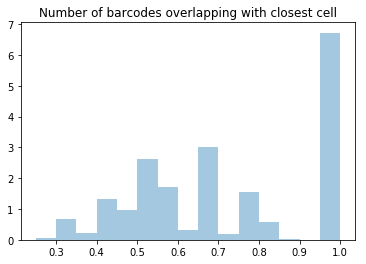

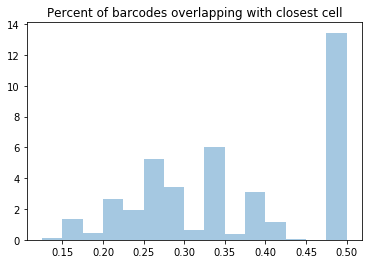

In [40]:
#How many of each cells' plasmids are seen in another cell?
def jaccardMatrix(m):
    return(scipy.sparse.csr_matrix(m*m.T/((scipy.sparse.csr_matrix(np.ones(m.shape))*m.T+m*scipy.sparse.csr_matrix(np.ones(m.shape)).T)-m*m.T)))

#m=bcann.X*bcann.X.T
m=jaccardMatrix(ctann.X)
m[np.where(np.isnan(m.todense()))]=0
diagmax=m.max(axis=0)
m.setdiag(0)        
#np.fill_diagonal(m,0)
overlapmax=m.max(axis=0)
print(overlapmax/diagmax)
seaborn.distplot(overlapmax.toarray(),kde=False,norm_hist=True)
plt.title('Number of barcodes overlapping with closest cell')
plt.show()
seaborn.distplot(overlapmax.toarray()/(diagmax.toarray()+1),kde=False,norm_hist=True)
plt.title('Percent of barcodes overlapping with closest cell')
plt.show()

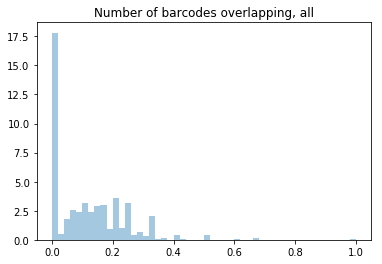

In [42]:
seaborn.distplot(m.toarray().flatten(),kde=False,norm_hist=True)
plt.title('Number of barcodes overlapping, all')
plt.show()


In [93]:
def discreteColormap(l):
    import matplotlib.pyplot as plt
    # create number for each group to allow use of colormap
    from itertools import count
    # get unique groups
    groups = set(l)
    mapping = dict(zip(sorted(groups),count()))
    colors = [mapping[i] for i in l]
    return(colors)

In [78]:
def barplotFromList(l):
    from collections import Counter
    import seaborn
    labels, values = zip(*Counter(l).items())
    indexes = np.arange(len(labels))
    width = 1
    seaborn.barplot(indexes, values)
    plt.xticks(indexes, labels)
    plt.show()

So it does appear that most cells share many barcodes with at least one other cells, though most cells do not share many with all the others. This is seen by the higher number of max barcodes overlapping than the dist of number overlapping for all

In [ ]:
k=3
import networkx as nx
G = nx.Graph()
G.add_nodes_from(range(m.shape[0]))
edges1=np.repeat(list(range(m.shape[0])),k)
#Take the top k notes to each node
edges2=m.toarray().argsort(axis=0)[-k:][::-1].T.flatten()
G.add_edges_from(list(zip(edges1, edges2)))
print(len(G.nodes))
isos=list(nx.algorithms.isolate.isolates(G))
G.remove_nodes_from(isos)

print(nx.number_connected_components(G))
g2=list(nx.connected_components(G))
communities=list(nx.algorithms.community.greedy_modularity_communities(G,2))

print([len(x) for x in  communities])
print(len(communities))

#Join k nearest nodes
k=3
for g2 in  communities:
    print(len(g2))
    m2=m[np.array(list(g2)),:]
    m2=m2[:,np.array(list(g2))]

    bcsub=bcann[np.array(list(g2)),:]

    labelannsub=labelann[[x for x in labelann.obs.index if x in bcsub.obs.index],:]
    bcsub.obs['Label']=labelann[[x for x in labelann.obs.index if x in bcsub.obs.index],:].obs['Label']
    bcsub.obs['Label'] = bcsub.obs['Label'].cat.add_categories(['Unknown'])
    bcsub.obs['Label'].fillna('Unknown', inplace =True)
    ctannsub=ctann[[x for x in ctann.obs.index if x in bcsub.obs.index],:]

    #seaborn.barplot(x=list(range(8)),y=np.array(np.sum(labelannsub.X,axis=0)).flatten())
    barplotFromList(bcsub.obs['Label'])
    plt.show()
    seaborn.clustermap(bcsub.X.todense()[0:4000,0:4000])
    plt.show()
    seaborn.clustermap(ctannsub.X.todense()[0:4000,0:4000])
    plt.show()
    seaborn.clustermap(np.log10(m2.todense()[0:4000,0:4000]+1))
    plt.show()
    if len(g2)<2000:
        Net = nx.Graph()
        Net.add_nodes_from(range(m2.shape[0]))
        edges1=np.repeat(list(range(m2.shape[0])),k)
        #Take the top k notes to each node
        edges2=m2.toarray().argsort(axis=0)[-k:][::-1].T.flatten()
        Net.add_edges_from(list(zip(edges1, edges2)))
        isos=list(nx.algorithms.isolate.isolates(Net))
        Net.remove_nodes_from(isos)
        nx.draw(Net, with_labels=False,node_size=5,node_color=discreteColormap(bcsub.obs['Label'].tolist()))
        plt.show()

In [280]:
comms=[]
inds=[]
for i in range(len(communities)):
    comms=comms+np.repeat(i,len(communities[i])).tolist()
    inds=inds+list(communities[i])
df=pd.DataFrame(comms,inds)
df.sort_index(inplace=True)

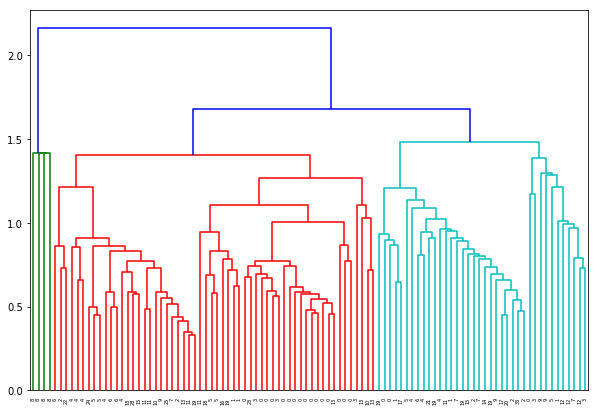

In [281]:
from scipy.cluster.hierarchy import dendrogram, linkage  
from matplotlib import pyplot as plt
sl=slice(0,100)
linked = scipy.cluster.hierarchy.average(1-m.todense()[sl,sl])

plt.figure(figsize=(10, 7))  
dendrogram(linked,  
            #orientation='top',
            labels=df.iloc[sl,0].tolist(),
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()  

In [282]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=72, linkage='average')  
clusters=cluster.fit_predict(1-m.todense()[0:3000])  

In [374]:
for c in set(clusters):
    print(c)
    print(clusters==c)
    seaborn.clustermap(ctann[0:3000,:].X.todense()[clusters==c,:])
    plt.show()

0
[False False False ... False False False]


ValueError: Must pass 2-d input

In [ ]:
for c in set(df.iloc[:,0]):
    print(c)
    seaborn.clustermap(ctann.X.todense()[df.iloc[:,0]==c,:][0:3000,:])
    plt.show()

In [ ]:
from collections import Counter
seaborn.distplot(list(Counter(clusters).values()),kde=False)
seaborn.distplot(list(Counter(df.iloc[0:3000,0]).values()),kde=False)

In [232]:
ctann

AnnData object with n_obs × n_vars = 6736 × 172 
    obs: 'Label', 'EpiClone', 'n_barcodes', 'n_genes', 'leiden'
    var: 'n_cells'
    uns: 'EpiClone_colors', 'Label_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [ ]:
import sklearn
sklearn.metrics.adjusted_rand_score(clusters, df.iloc[0:3000,0])

In [291]:
def graphCluster(X,k=3,jaccard=True):
    def jaccardMatrix(m):
        return(scipy.sparse.csr_matrix(m*m.T/((scipy.sparse.csr_matrix(np.ones(m.shape))*m.T+m*scipy.sparse.csr_matrix(np.ones(m.shape)).T)-m*m.T)))
    if jaccard:
        m=jaccardMatrix(X)
    else:
        m=X*X.T
    m[np.where(np.isnan(m.todense()))]=0
    diagmax=m.max(axis=0)
    m.setdiag(0)        
    import networkx as nx
    import pandas as pd
    G = nx.Graph()
    G.add_nodes_from(range(m.shape[0]))
    edges1=np.repeat(list(range(m.shape[0])),k)
    #Take the top k notes to each node
    edges2=m.toarray().argsort(axis=0)[-k:][::-1].T.flatten()
    G.add_edges_from(list(zip(edges1, edges2)))
    #isos=list(nx.algorithms.isolate.isolates(G))
    #G.remove_nodes_from(isos)
    communities=list(nx.algorithms.community.greedy_modularity_communities(G,2))
    comms=[]
    inds=[]
    for i in range(len(communities)):
        comms=comms+np.repeat(i,len(communities[i])).tolist()
        inds=inds+list(communities[i])
    df=pd.DataFrame(comms,inds)
    df.sort_index(inplace=True)
    return(df[0].tolist(),m)

In [385]:
import sklearn
bccl,m=graphCluster(bcann.X[0:3000,:],3,False)
hclusting = AgglomerativeClustering(n_clusters=len(set(bccl)), linkage='average')  
bchclusts=hclusting.fit_predict(m.todense())  
sklearn.metrics.adjusted_rand_score(bchclusts, bccl)

/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/sklearn/cluster/hierarchical.py:471: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


ValueError: labels_true and labels_pred must have same size, got 6736 and 3000

In [363]:
cl,m=graphCluster(ctann.X[0:3000,:],3,True)
hclusting = AgglomerativeClustering(n_clusters=len(set(cl)), linkage='average')  
hclusts=hclusting.fit_predict(1-m.todense())  
sklearn.metrics.adjusted_rand_score(hclusts, cl)

0.3817971167192635

In [368]:
print(sklearn.metrics.adjusted_rand_score(bchclusts, hclusts))
print(sklearn.metrics.adjusted_rand_score(cl, bccl))
print(sklearn.metrics.adjusted_rand_score(bchclusts, cl))


-0.004790409727024412
-0.00016152828304325447
-0.009014628100732166


In [388]:
cl,m=graphCluster(ctann.X,3,True)
bccl,bcm=graphCluster(bcann.X,3,False)

0


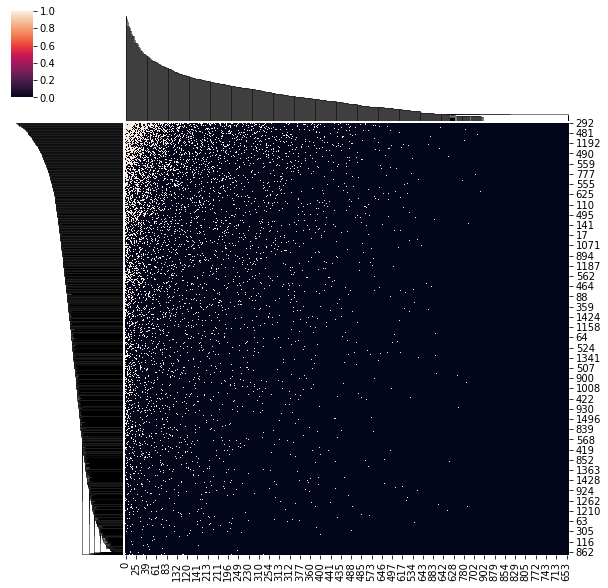

/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


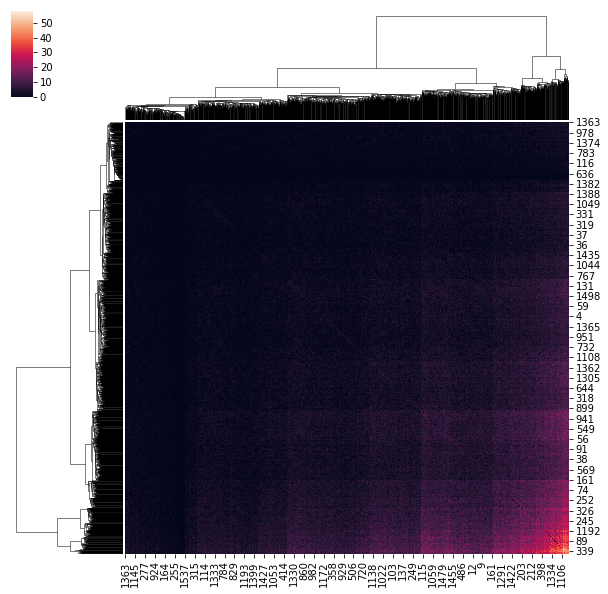

1


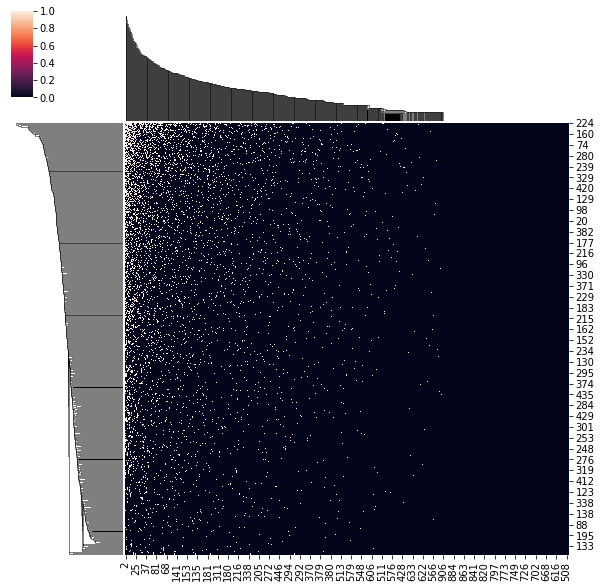

/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


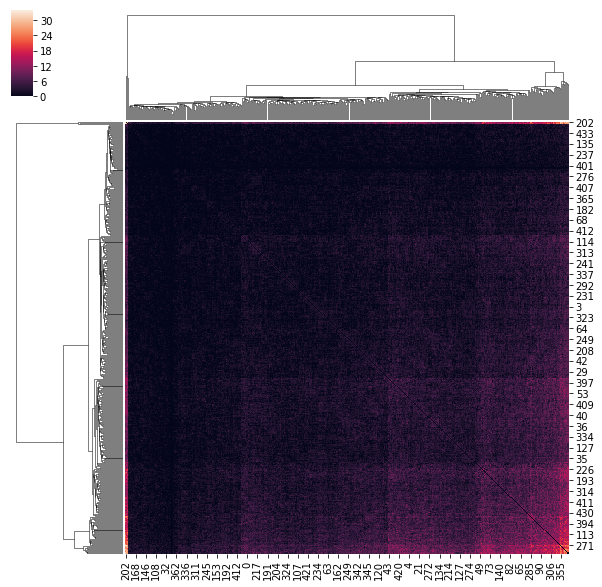

2


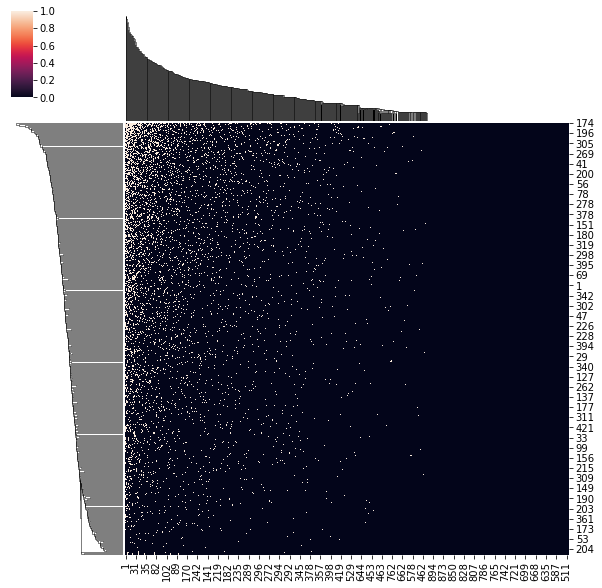

/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


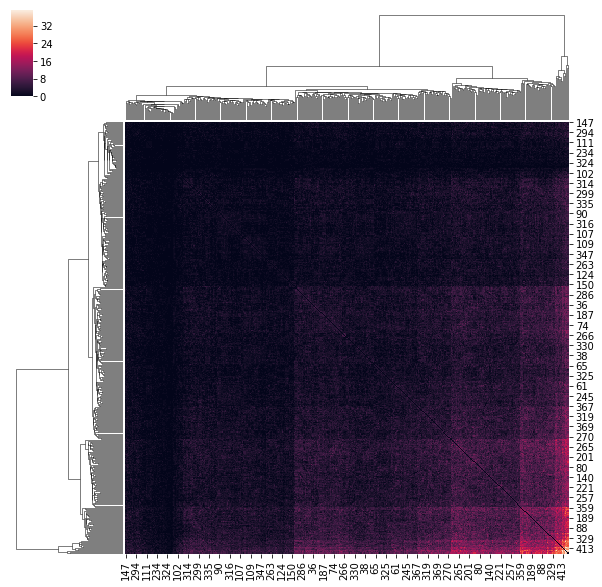

3


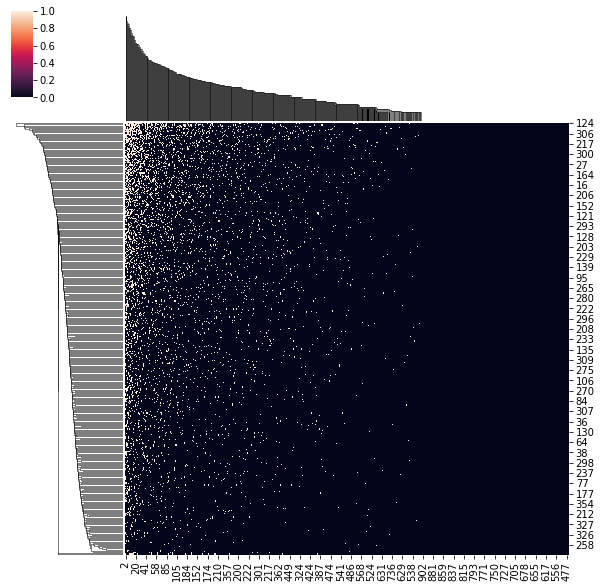

/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


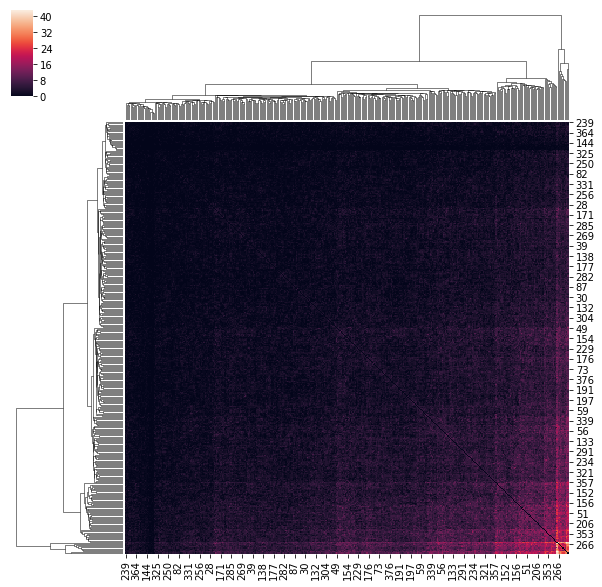

4


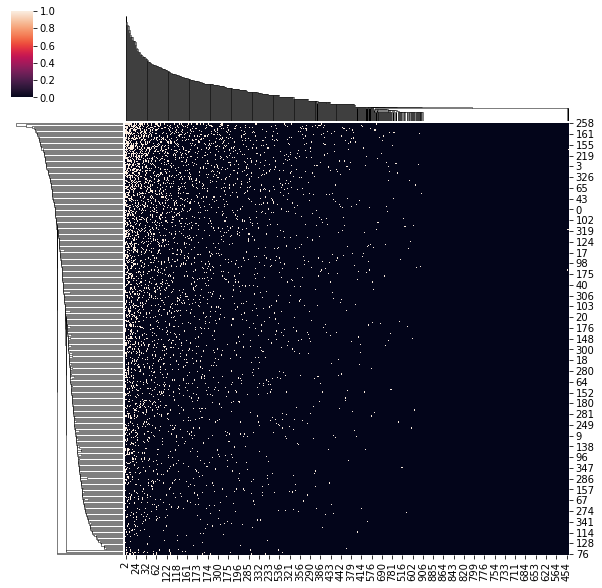

/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


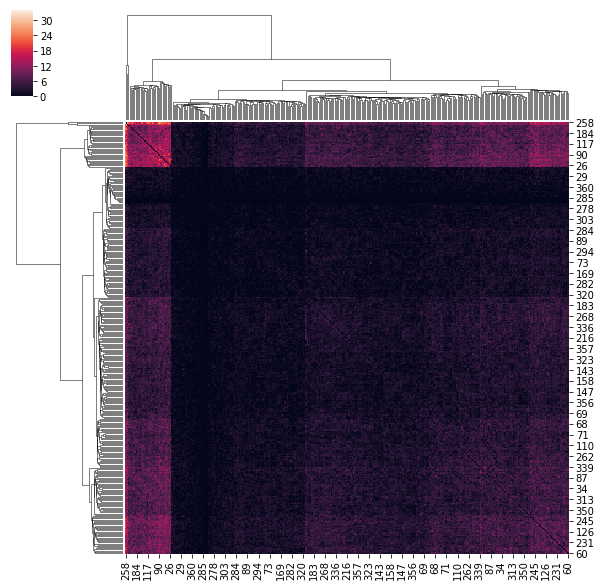

5


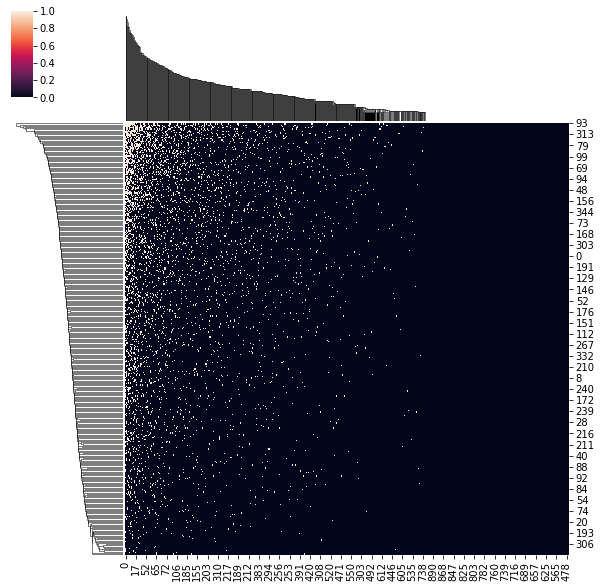

/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


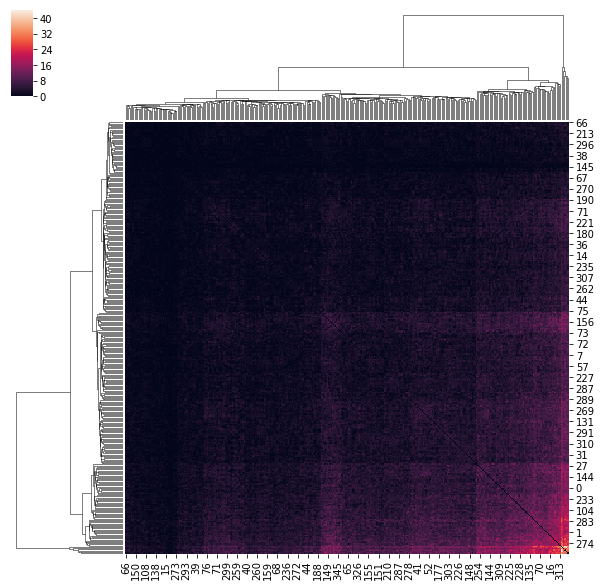

6


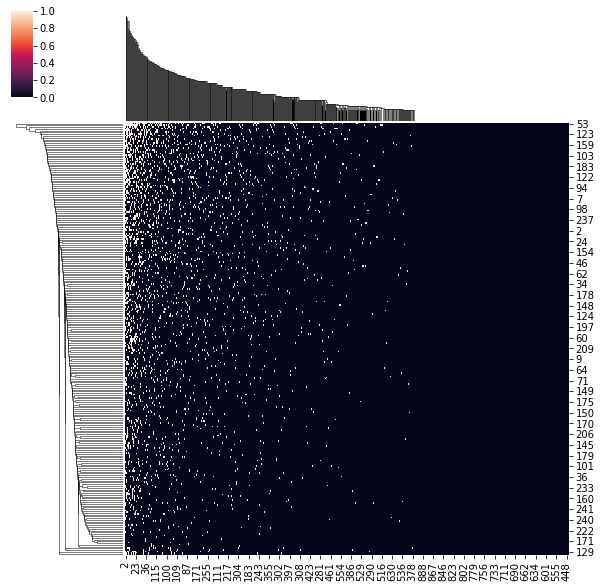

/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


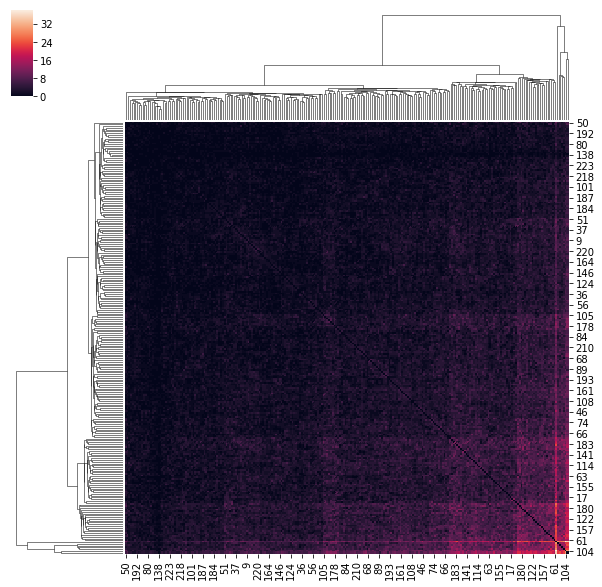

7


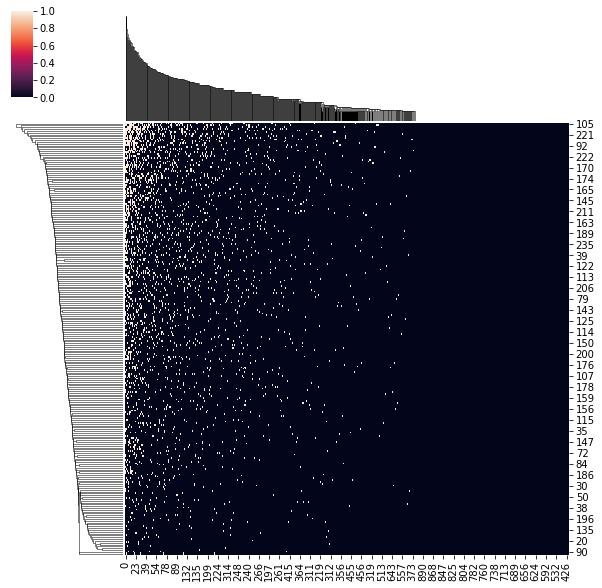

/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


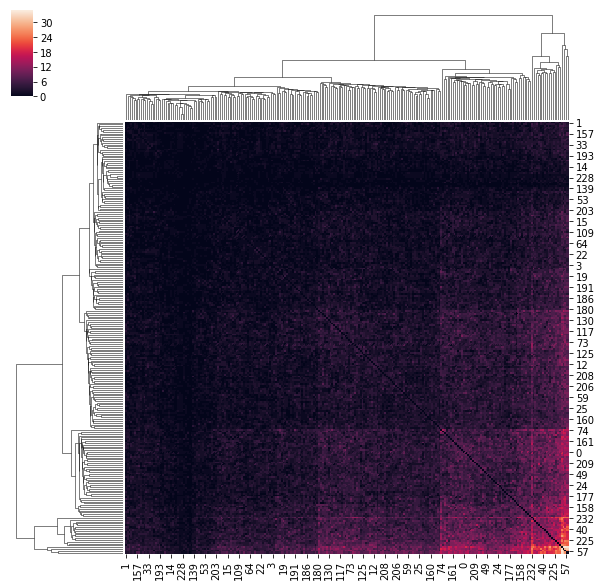

8


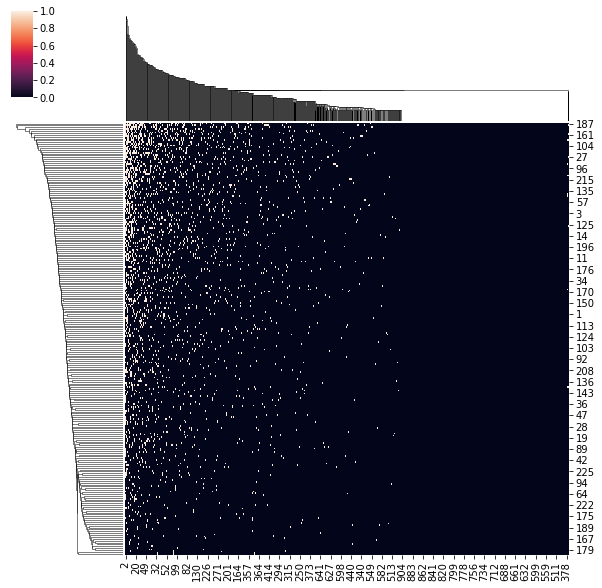

/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


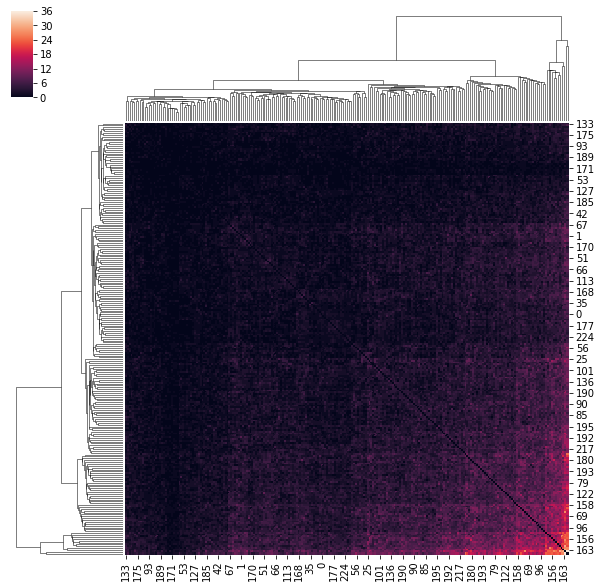

9


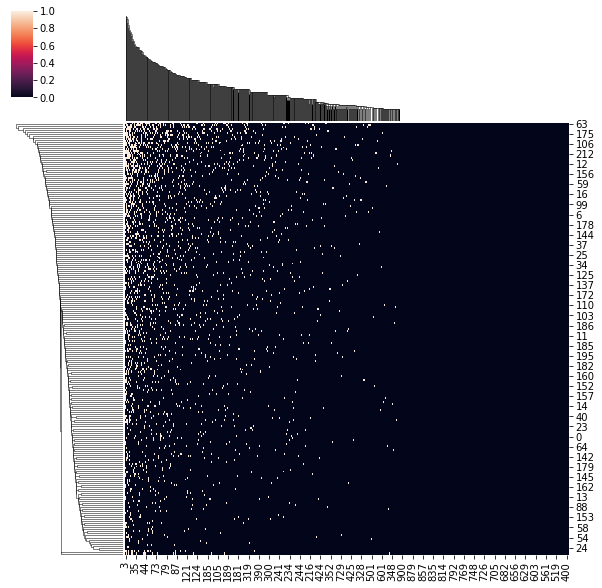

/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


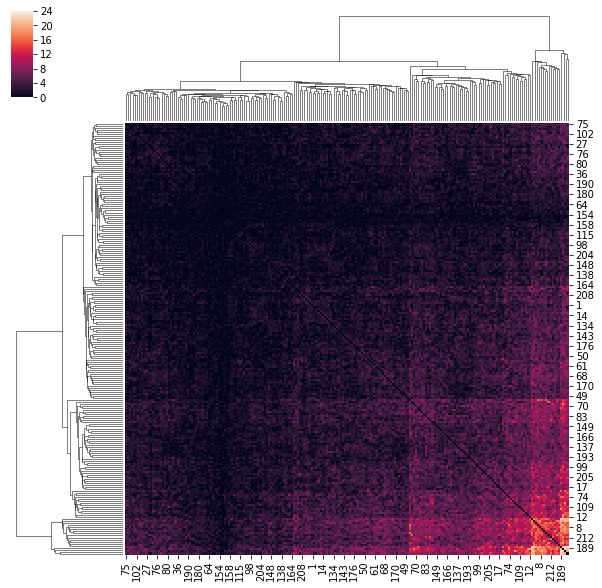

10


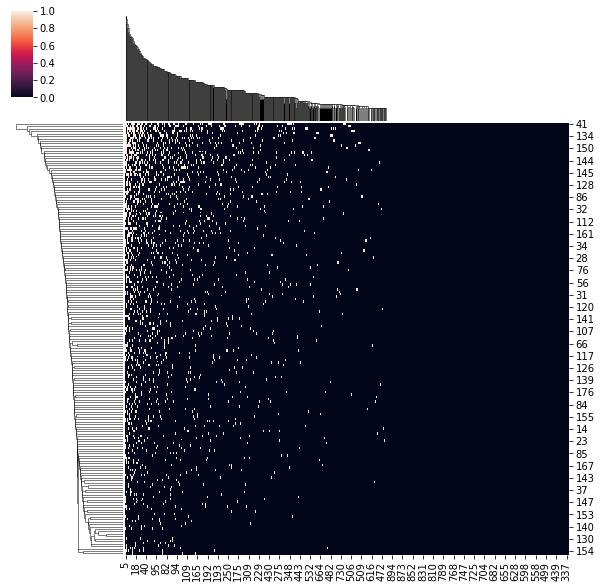

/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


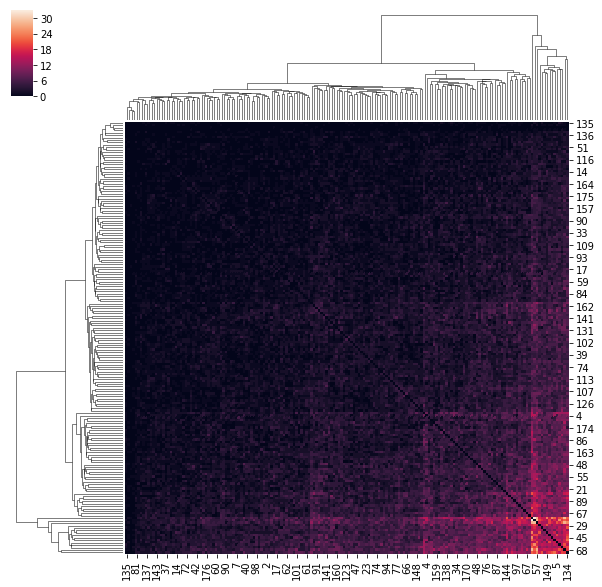

11


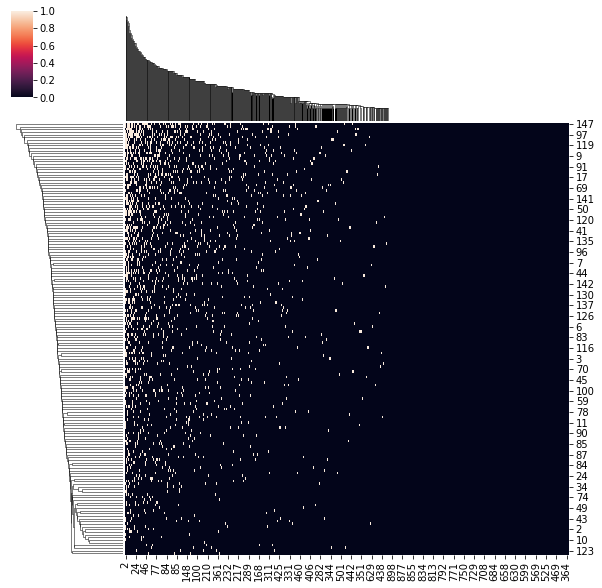

/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


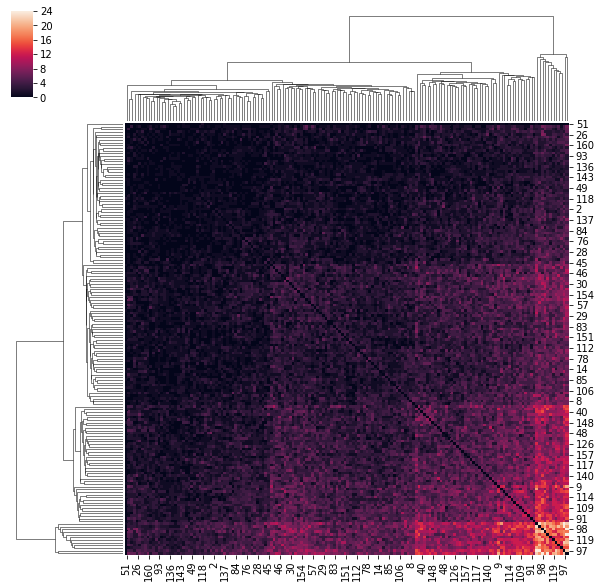

12


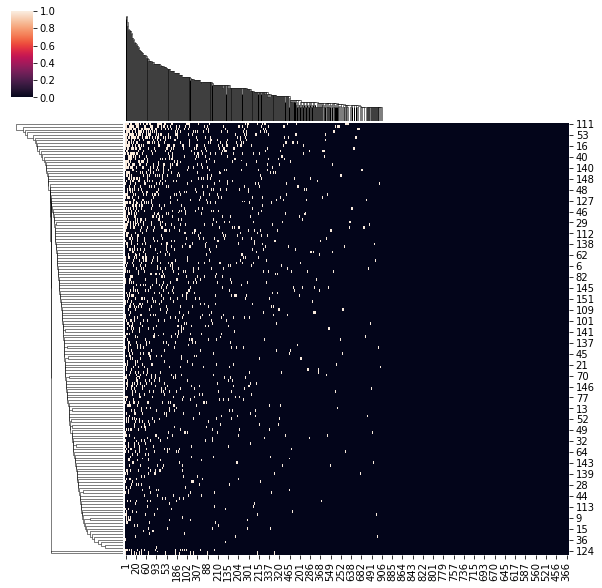

/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


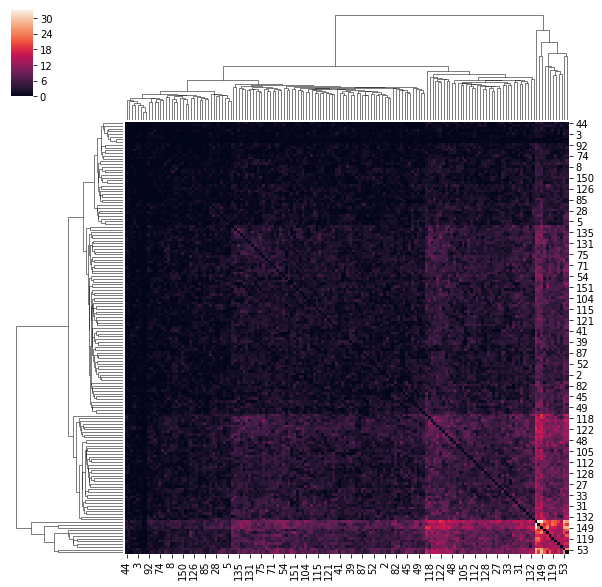

13


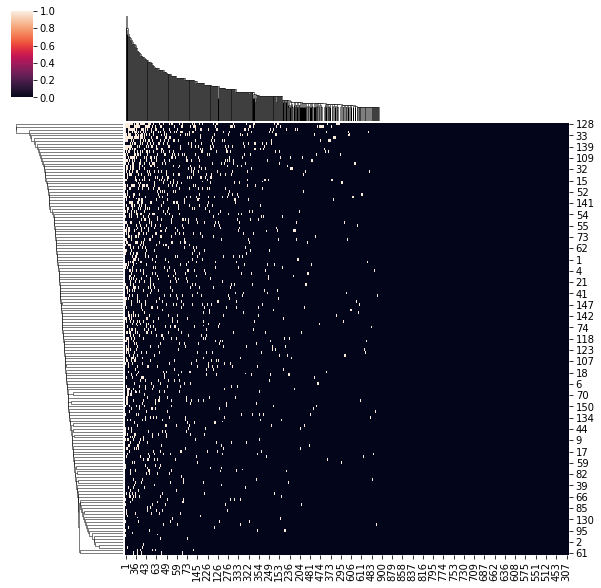

/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


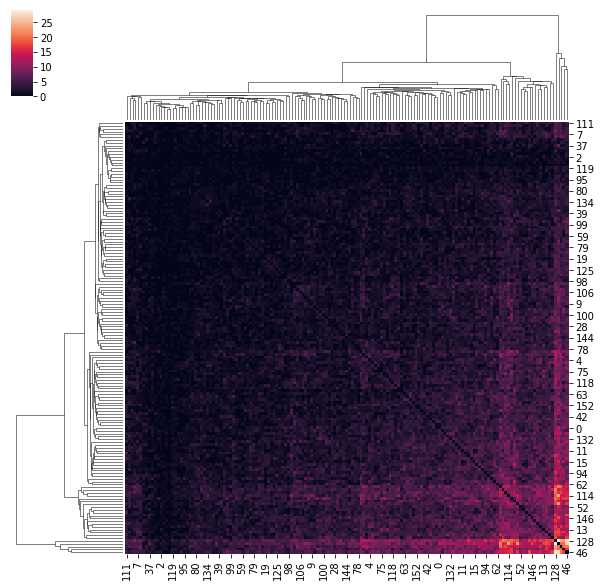

14


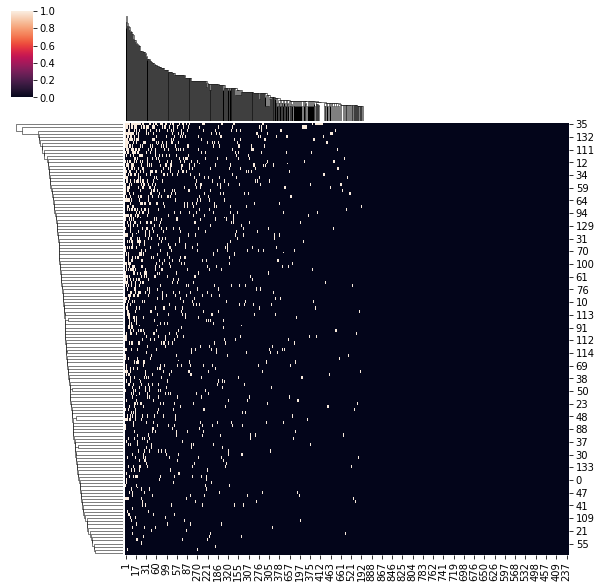

/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


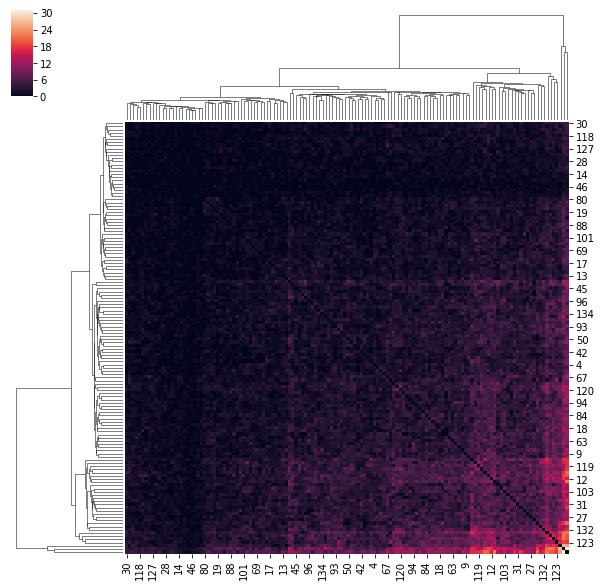

15


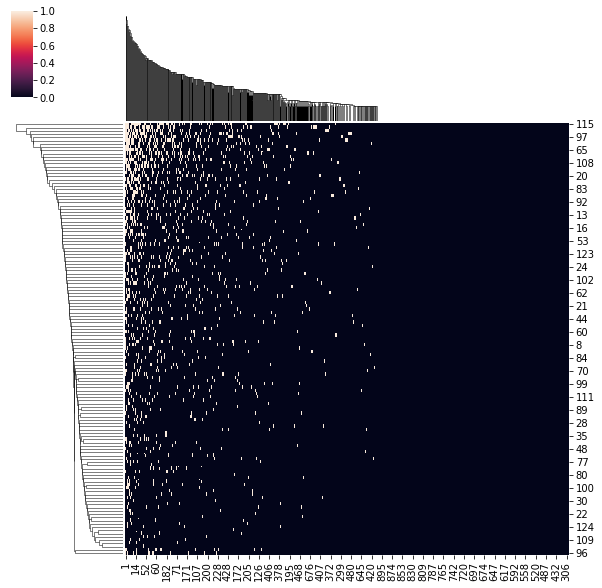

/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


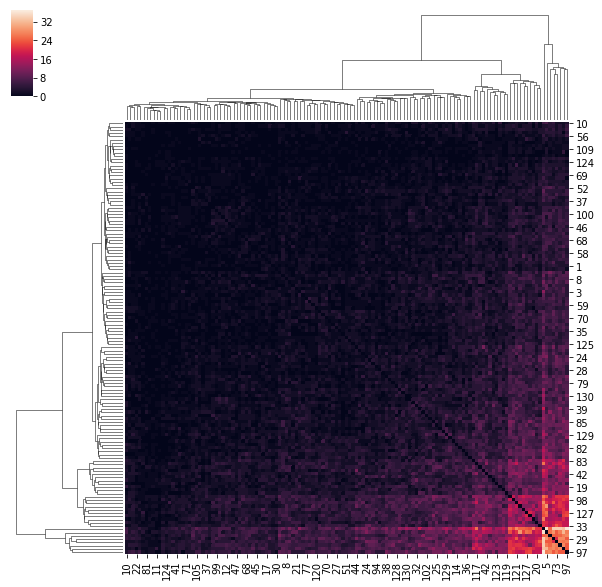

16


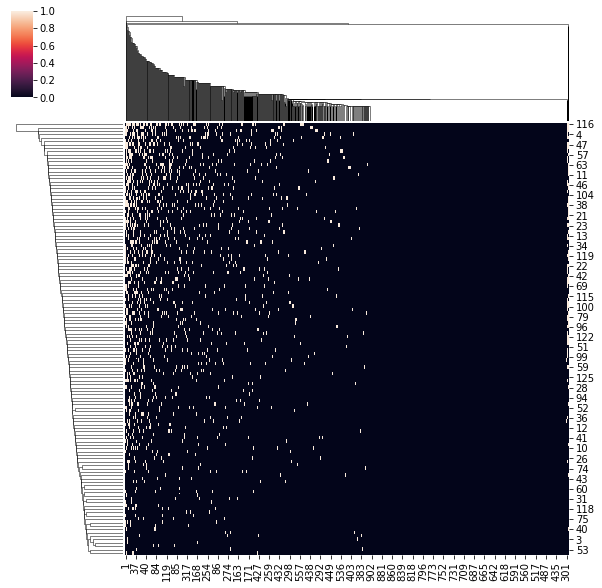

/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


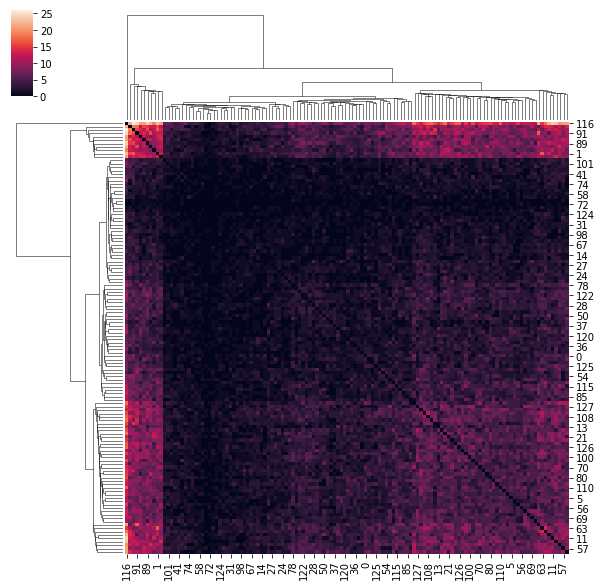

17


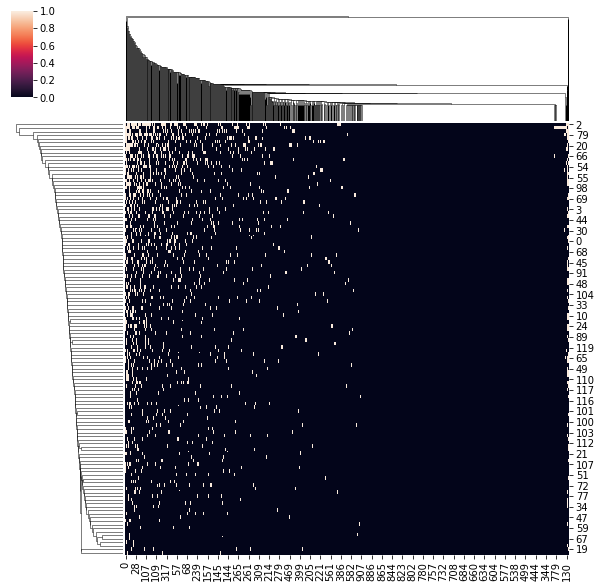

/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


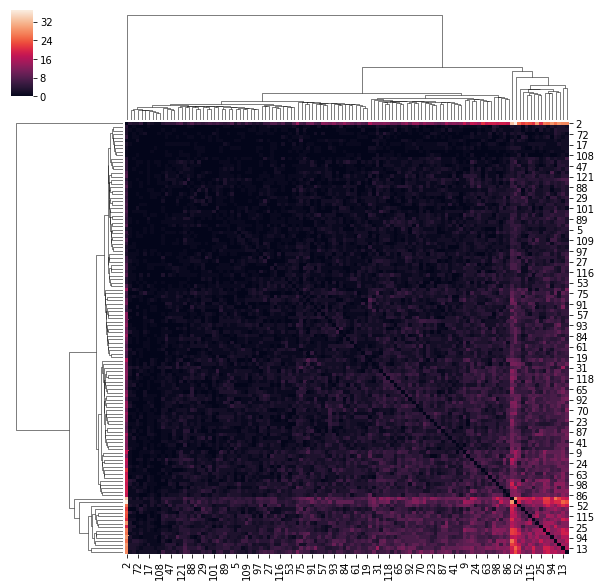

18


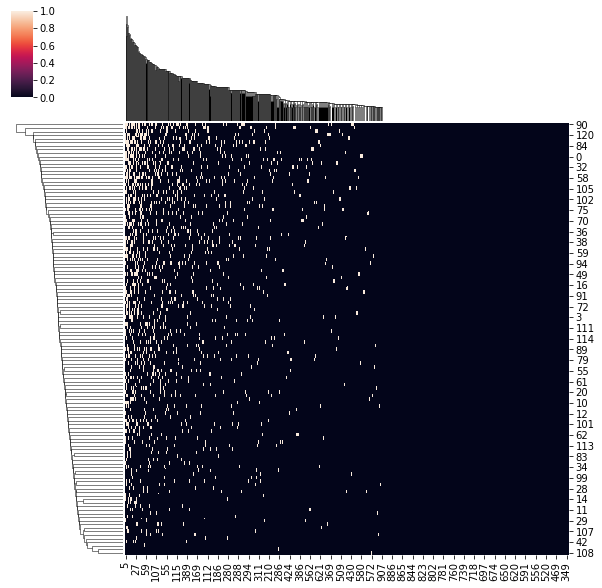

/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


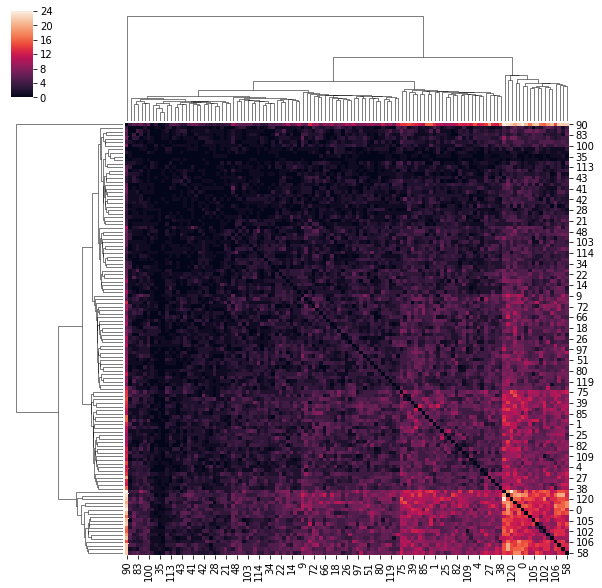

19


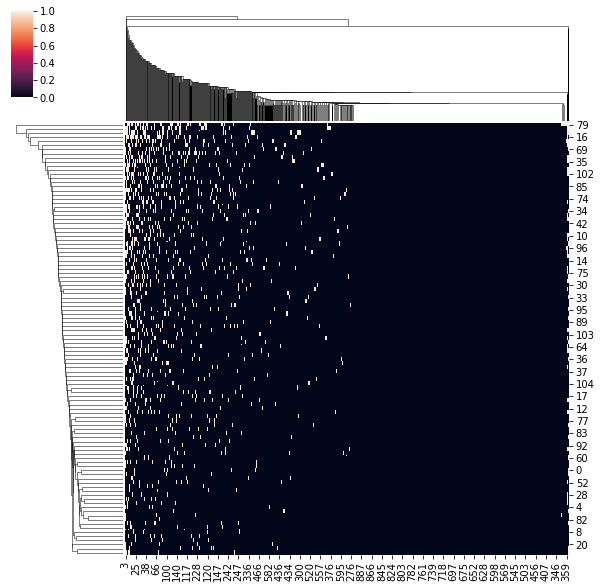

/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


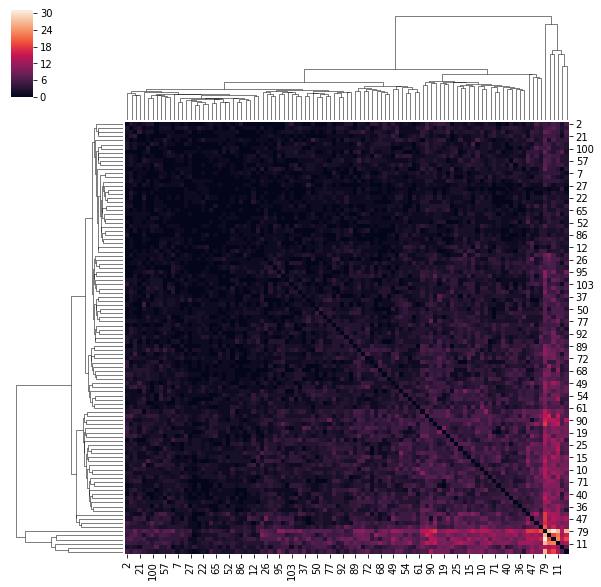

20


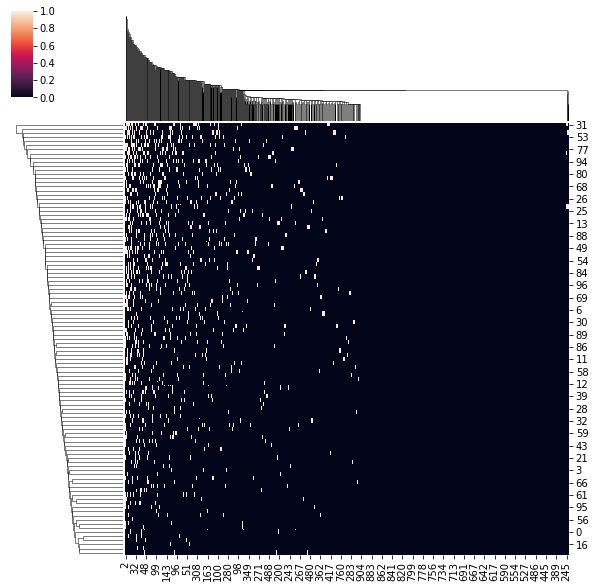

/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


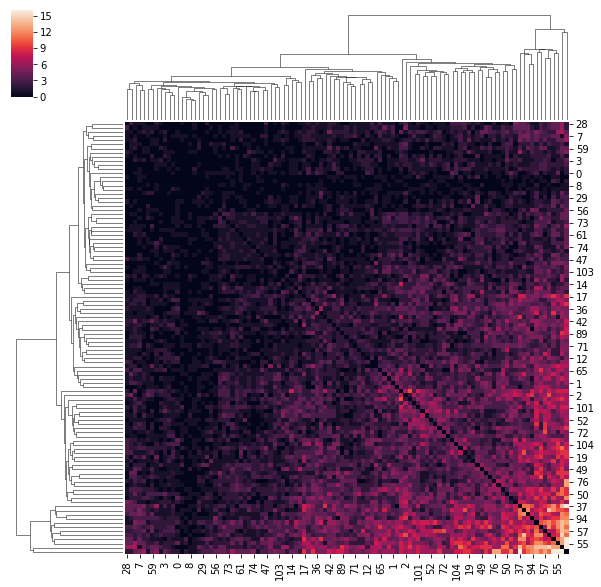

21


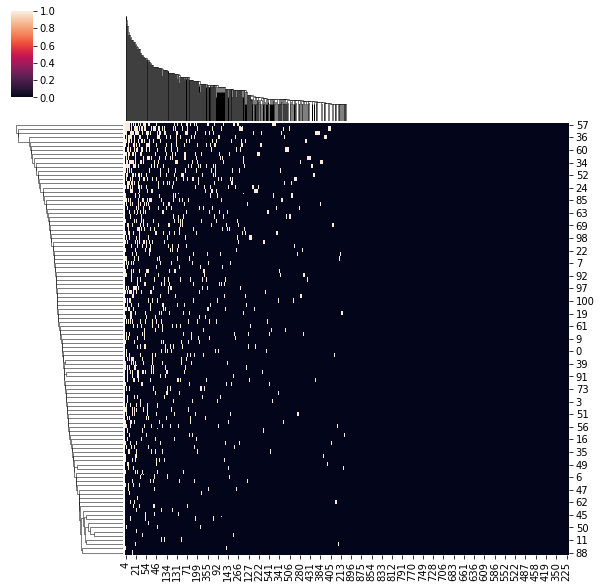

/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


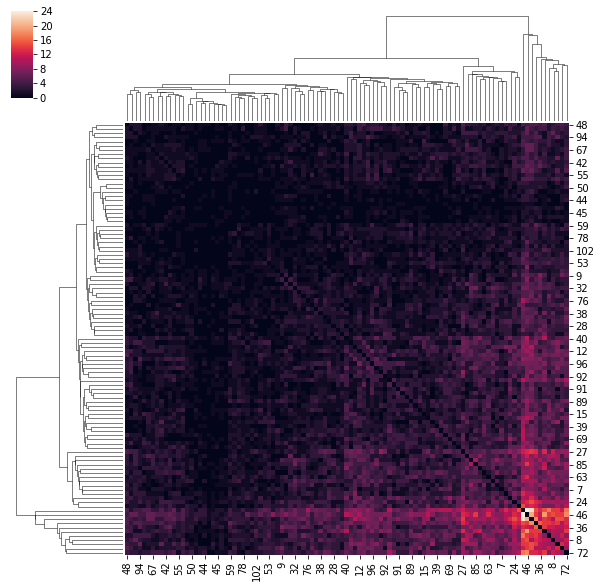

22


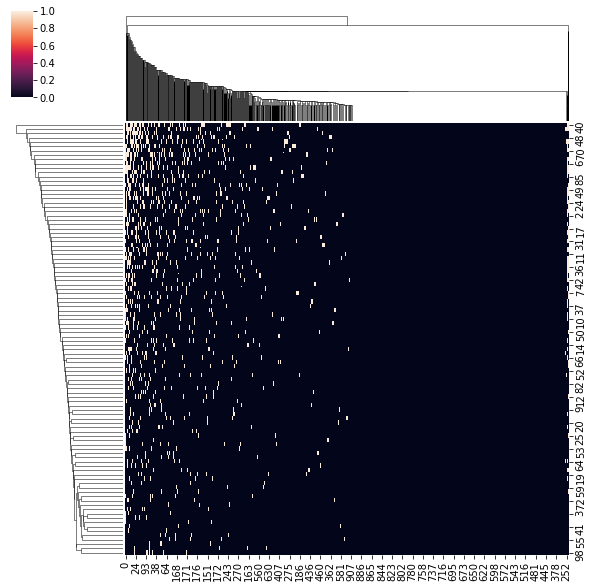

/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


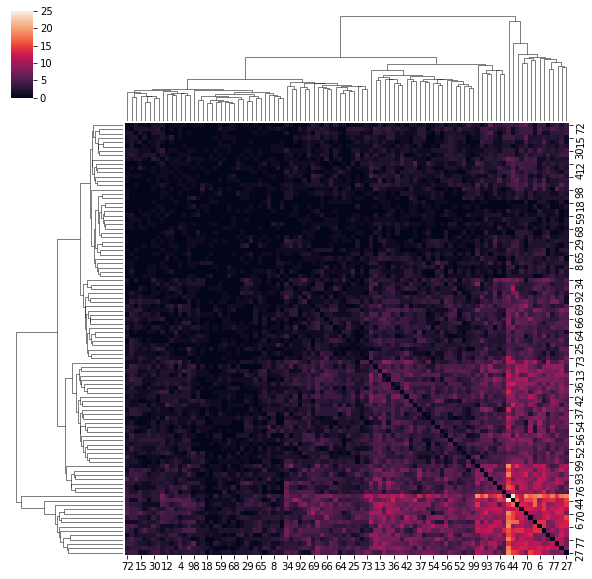

23


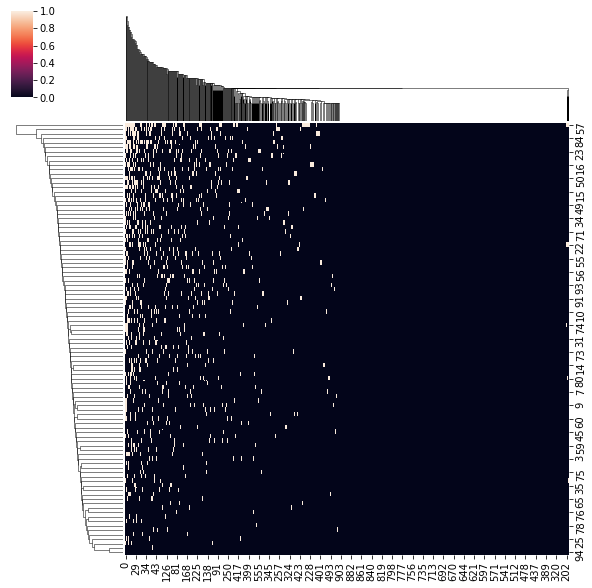

/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


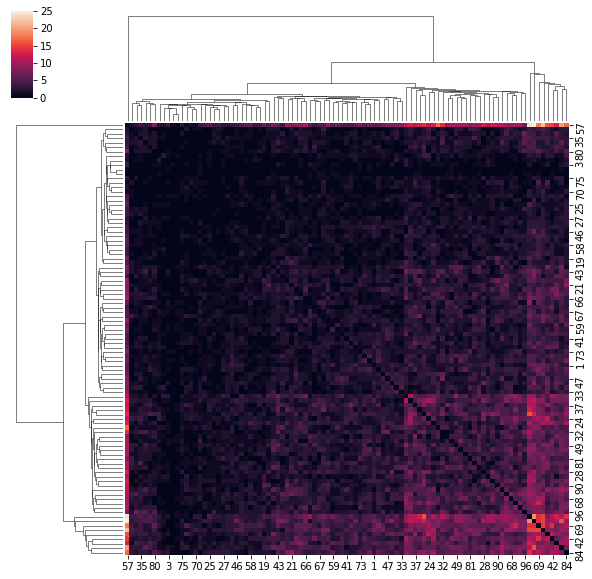

24


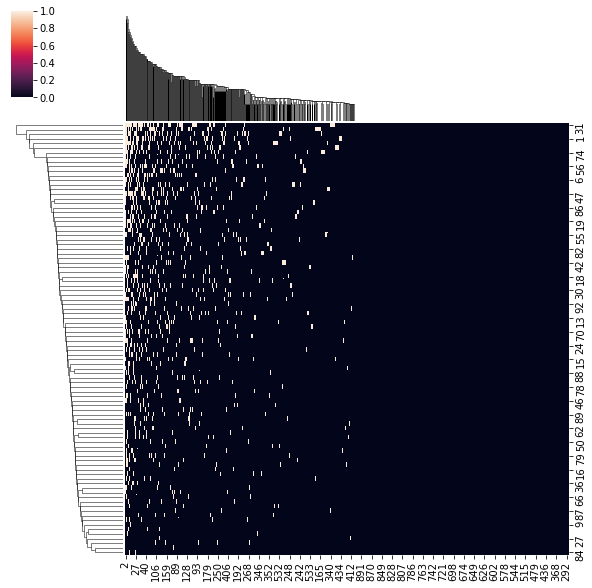

/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


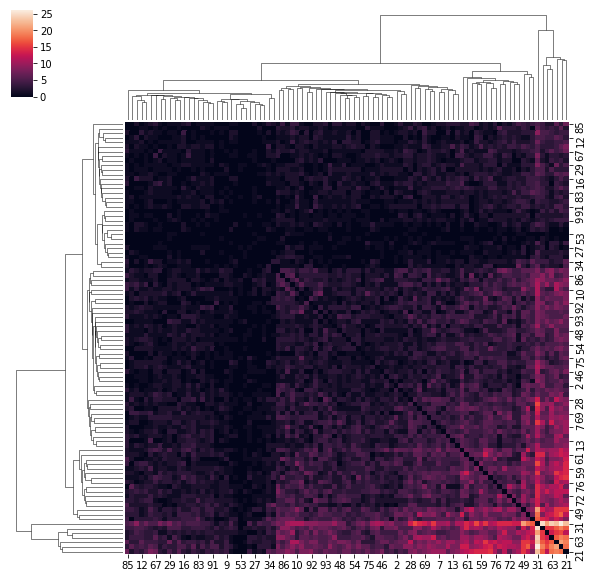

25


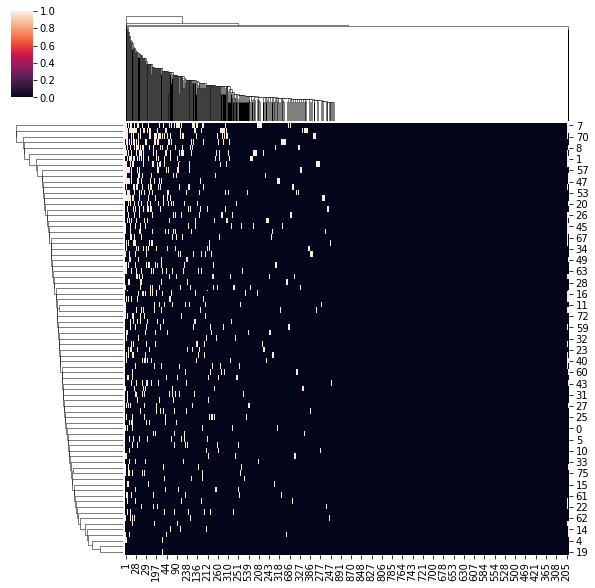

/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


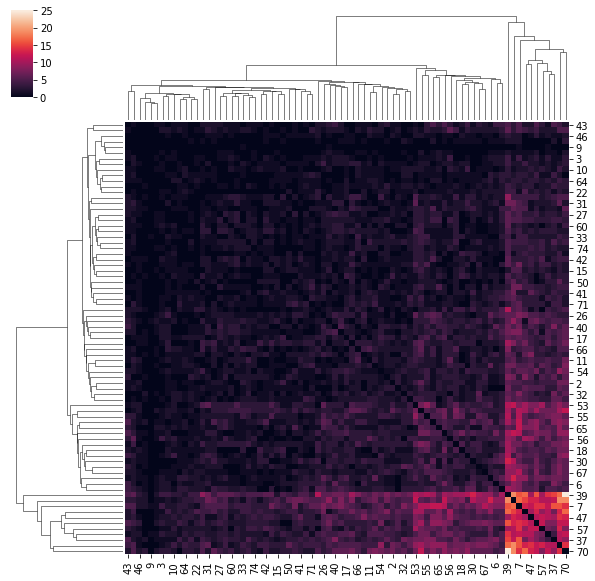

26


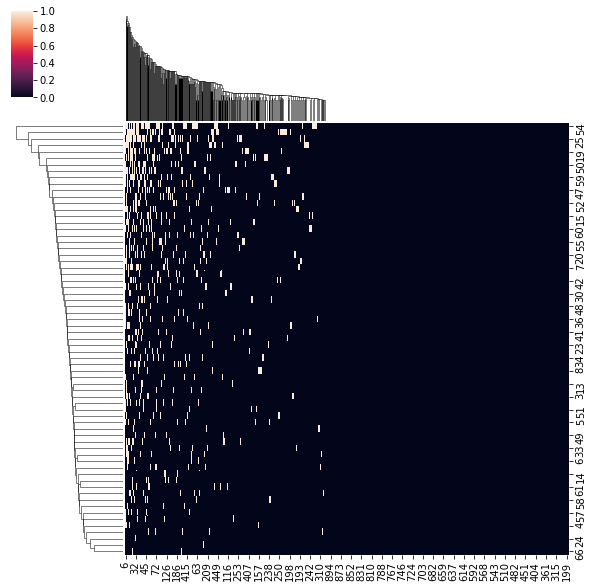

/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


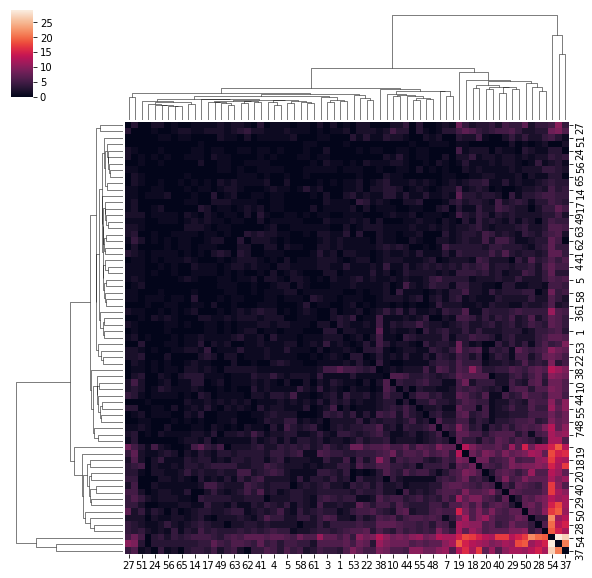

27


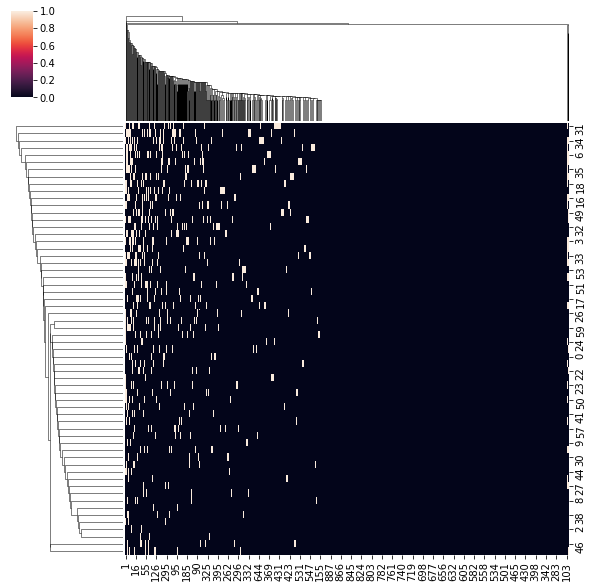

/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


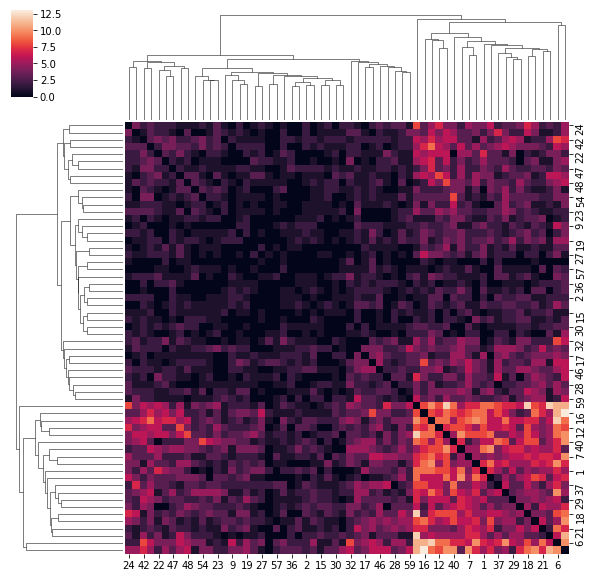

28


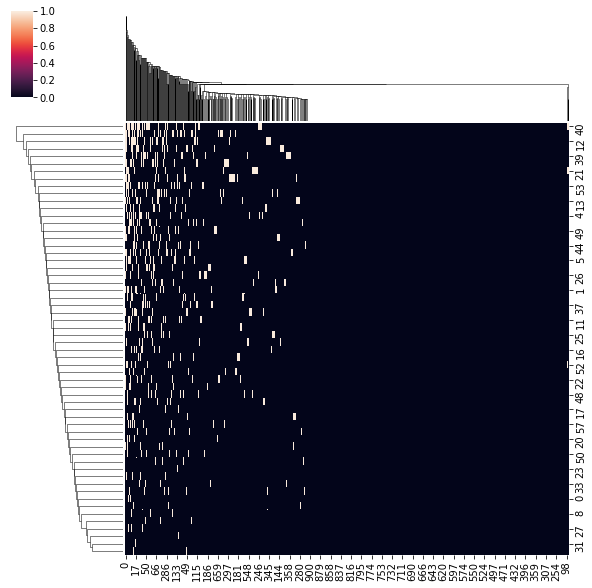

/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


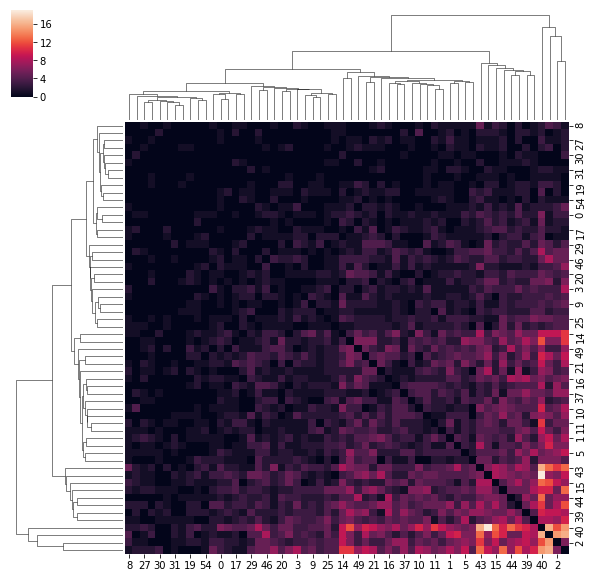

29


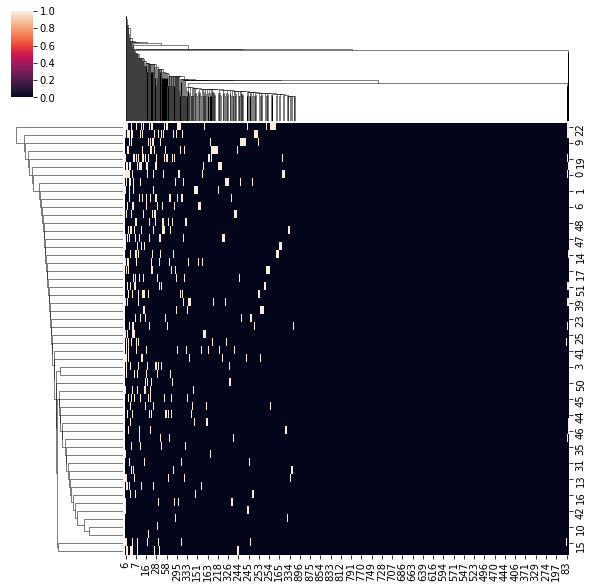

/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


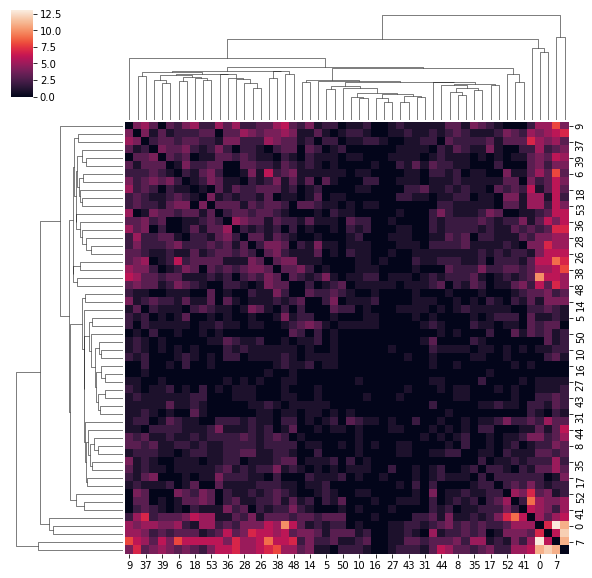

30


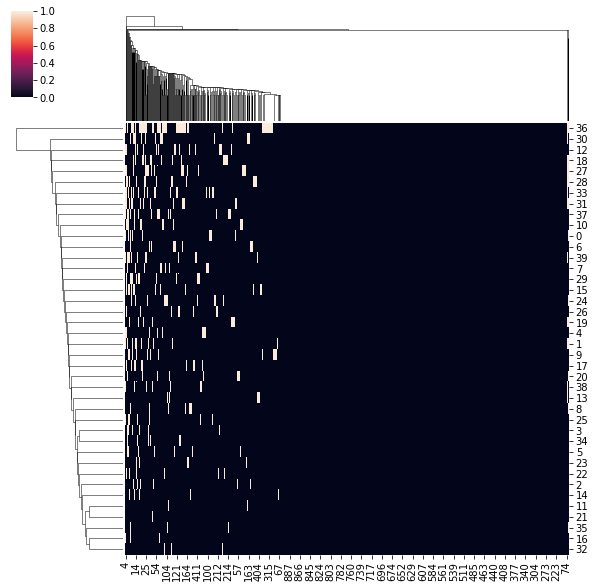

/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


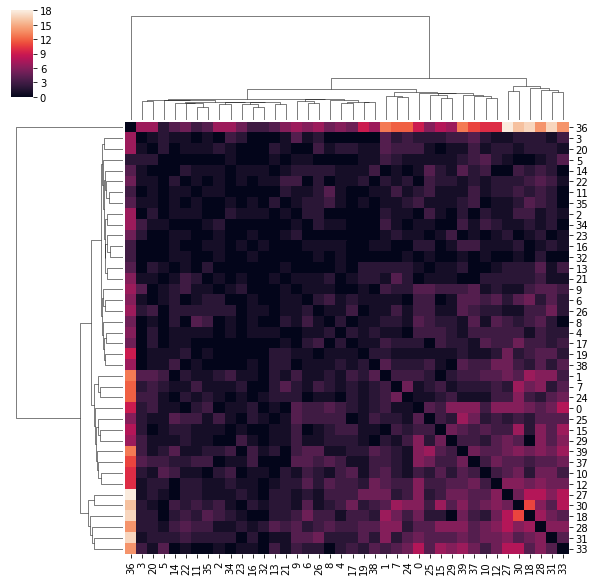

31


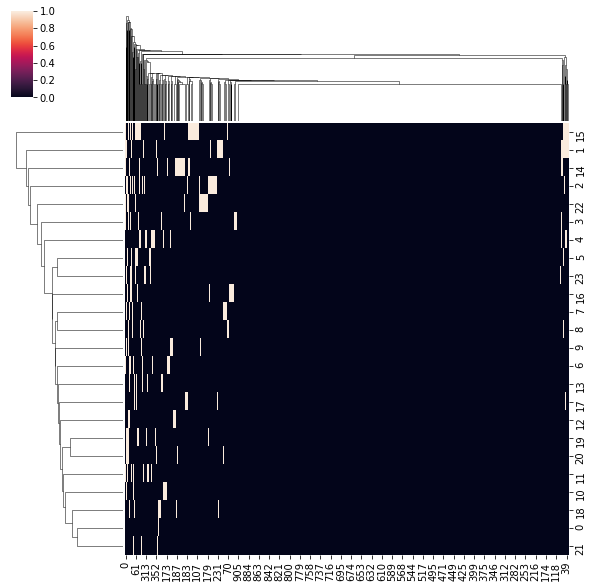

/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


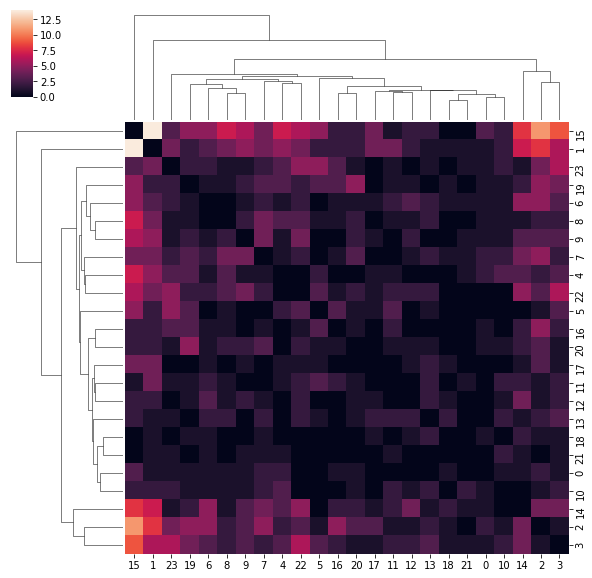

32


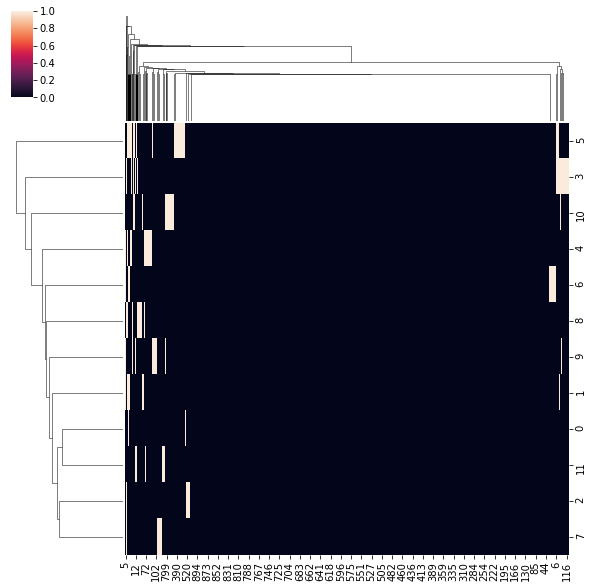

/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


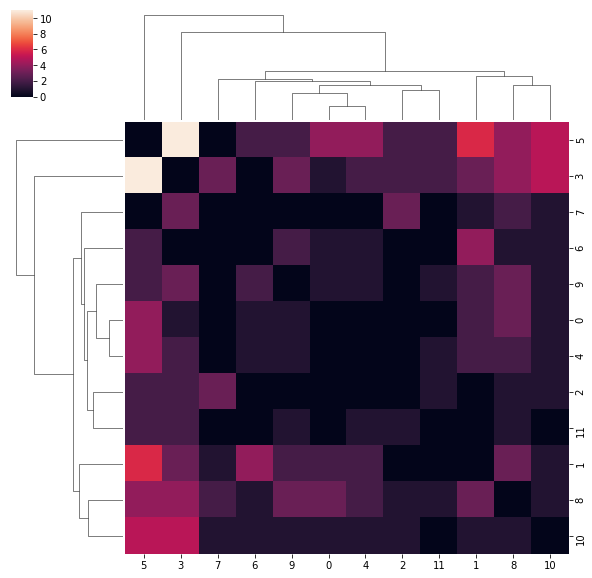

33


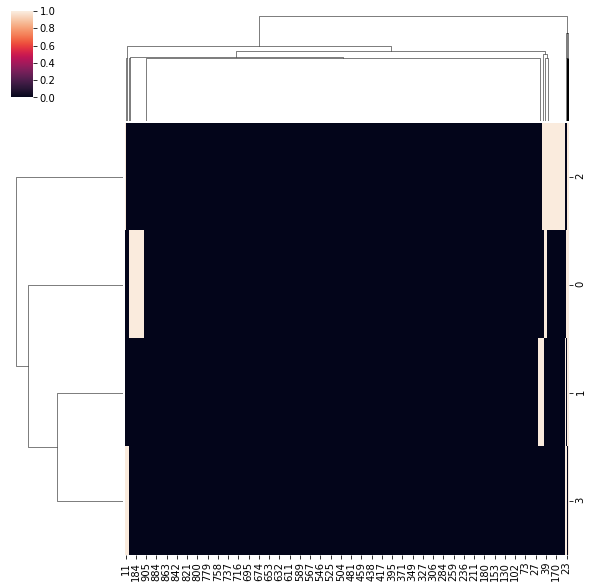

/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


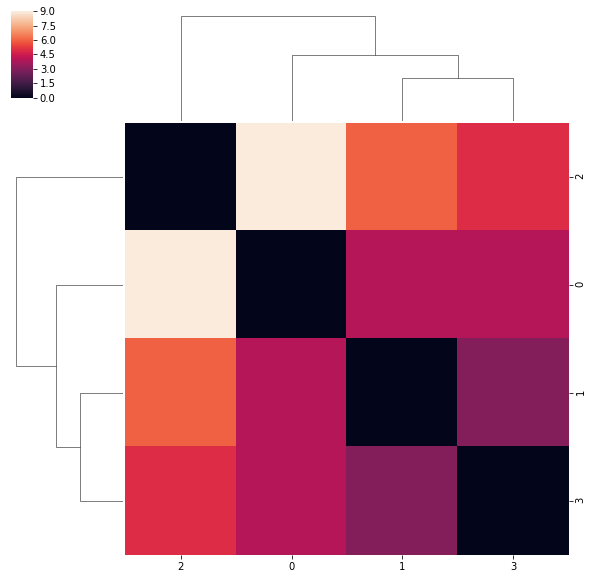

34


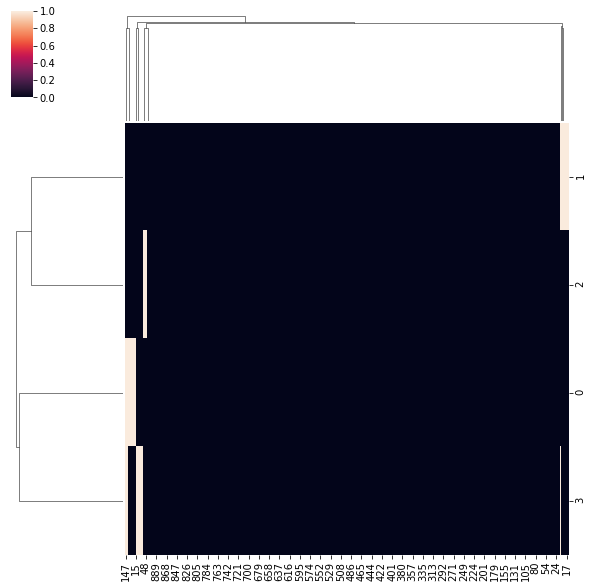

/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


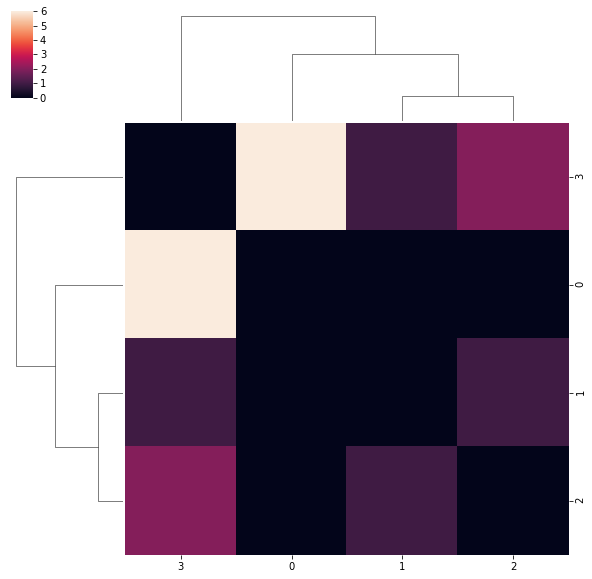

In [427]:
for c in set(cl):
    print(c)
    seaborn.clustermap(bcann[np.array(cl)==c,:].X.todense())
    plt.show()
    seaborn.clustermap(bcm[np.where(np.array(cl)==c)[0],:][:,np.where(np.array(cl)==c)[0]].todense())
    plt.show()

In [ ]:
adata.obs.groupby(['LentiClone','EpiClone'])['EpiClone'].count().plot.barh()

In [ ]:
adata.obs.groupby(['leiden','LentiClone'])['LentiClone'].count().plot.barh()

In [ ]:
adata.obs.groupby('Label')['Label'].count()

In [ ]:
#2B07, very large single clone
adata6=adata[adata.obs['Label']=='BC6',:]
bcann6=bcann[[x for x in bcann.obs.index if x in adata6.obs.index],:]
ctann6=ctann[[x for x in ctann.obs.index if x in adata6.obs.index],:]
print(adata6)
print(bcann6)
print(ctann6)
seaborn.clustermap(bcann6.X.todense()[0:3500,0:3500])
seaborn.clustermap(ctann6.X.todense()[0:3500,0:3500])
#sc.pl.umap(adata6,color=['Label','leiden','EpiClone','LentiClone'])

In [ ]:
import matplotlib.pyplot as plt
seaborn.distplot(corrs)
seaborn.distplot(randocorrs)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
ax = plt.axes()
seaborn.distplot(np.sum(bcann6.X,axis=1))
ax.set_title('Barcodes per cell, clone 6')
print(np.sum(bcann6.X,axis=0).shape)
plt.show()
seaborn.clustermap(np.log10((bcann6.X[0:3500,0:3000]*bcann6.X[0:3500,0:3000].T).todense()+1))
seaborn.clustermap(np.log10((ctann6.X[0:3500,0:3000]*ctann6.X[0:3500,0:3000].T).todense()+1))

plt.show()
m=(bcann6.X * bcann6.X.T).todense()
print(m)
np.fill_diagonal(m,0)
print(m)
ax = plt.axes()
seaborn.distplot(np.max(m,axis=1).flatten())
ax.set_title('Max barcodes overlap with another cell, clone 6')


In [ ]:
import networkx as nx
m = bcann6.X * bcann6.X.T
m[m<=3]=0
G = nx.from_scipy_sparse_matrix(m)
print('G written')
nx.draw(G, with_labels=False)

In [ ]:
#One Small clone
adata4=adata[adata.obs['Label']=='BC4',:]
bcann4=bcann[[x for x in bcann.obs.index if x in adata4.obs.index],:]
ctann4=ctann[[x for x in ctann.obs.index if x in adata4.obs.index],:]
print(adata4)
print(bcann4)
print(ctann4)
seaborn.clustermap(bcann4.X.todense())
seaborn.clustermap(ctann4.X.todense())
sc.pl.umap(adata4,color=['Label','leiden','EpiClone','LentiClone'])

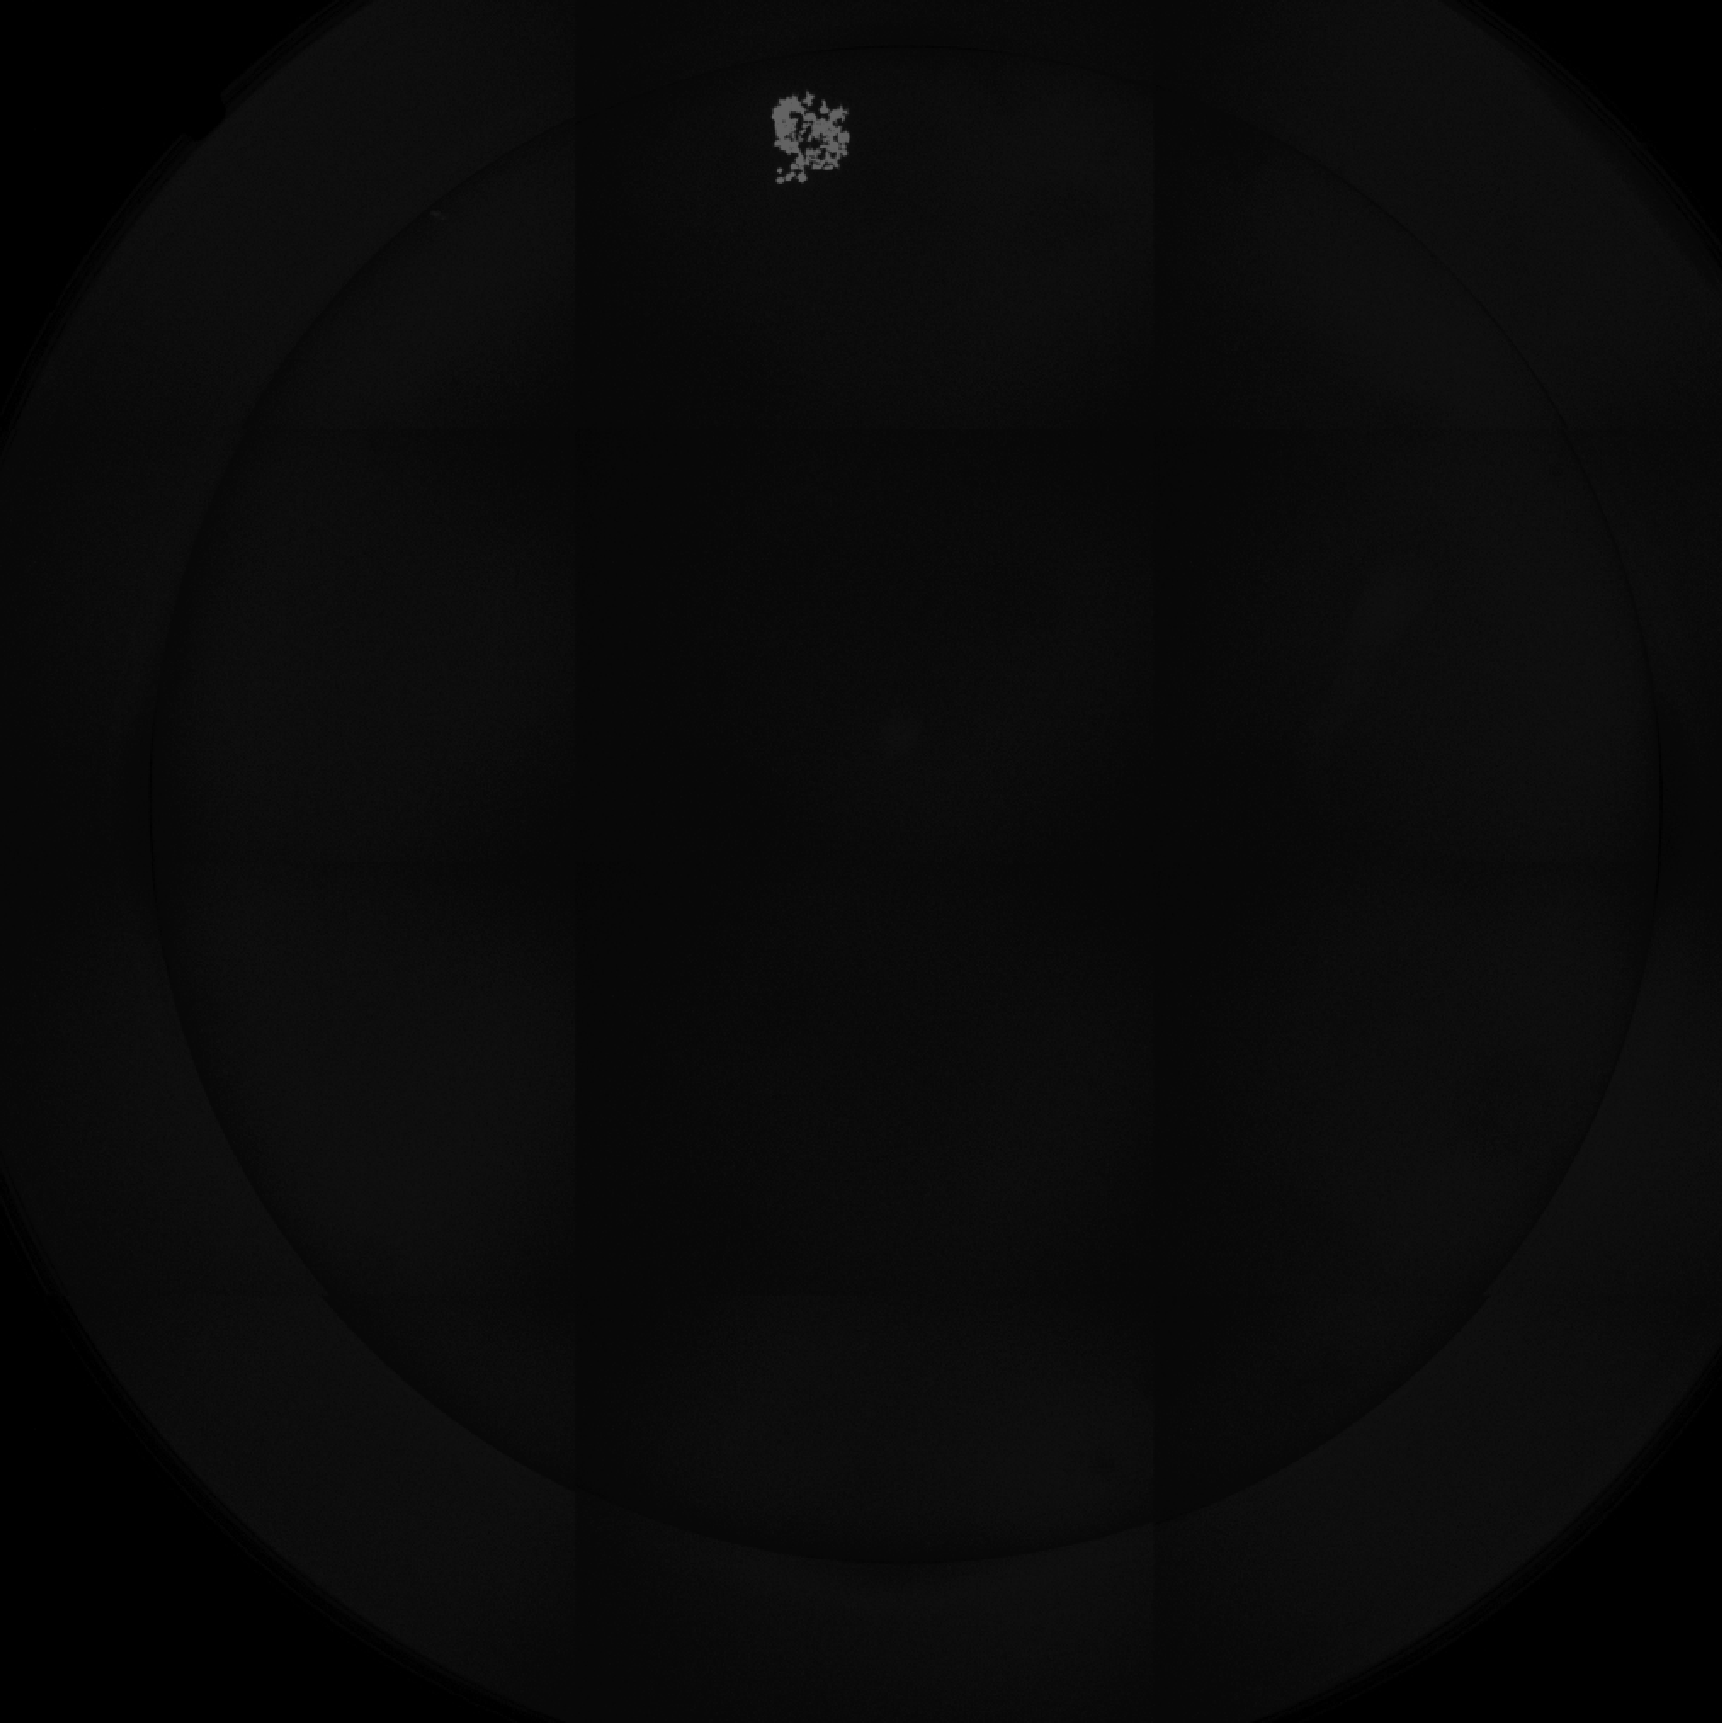

In [ ]:
adata7=adata[adata.obs['Label']=='BC7',:]
bcann7=bcann[[x for x in bcann.obs.index if x in adata7.obs.index],:]
ctann7=ctann[[x for x in ctann.obs.index if x in adata7.obs.index],:]
print(adata7)
print(bcann7)
print(ctann7)
seaborn.clustermap(bcann7.X.todense())
seaborn.clustermap(ctann7.X.todense())
sc.pl.umap(adata7,color=['Label','leiden','EpiClone','LentiClone'])

In [ ]:
import networkx as nx
m = bcann7.X * bcann7.X.T
m.setdiag(0)
m[m<1]=0
m.eliminate_zeros()
G = nx.from_scipy_sparse_matrix(m)
isos=list(nx.algorithms.isolate.isolates(G))
G.remove_nodes_from(isos)
print('G written')
nx.draw(G, with_labels=True)


In [ ]:
import matplotlib.pyplot as plt
ax = plt.axes()
seaborn.distplot(np.sum(bcann7.X,axis=1))
ax.set_title('Barcodes per cell, clone 7')


In [ ]:
seaborn.heatmap(np.log10((bcann7.X * bcann7.X.T).todense()+1))
plt.show()
seaborn.heatmap(np.log10((ctann7.X * ctann7.X.T).todense()+1))

In [ ]:
import random
cells7=list(set(adata7.obs.index).intersection(set(bcann7.obs.index),set(ctann7.obs.index)))
adata7=adata7[cells7,:]
bcann7=bcann7[cells7,:]
ctann7=ctann7[cells7,:]
bcx=(bcann7.X*bcann7.X.T).todense()
ctx=(ctann7.X*ctann7.X.T).todense()
corrs=[]
for i in range(bcx.shape[0]):
    corrs.append(np.corrcoef(bcx[i,:], ctx[i,:])[1,0])

randocorrs=[]
for i in range(bcx.shape[0]):
    randocorrs.append(np.corrcoef(bcx[i,:], ctx[random.randint(0,bcx.shape[0]-1),:])[1,0])
import matplotlib.pyplot as plt
seaborn.distplot(corrs)
seaborn.distplot(randocorrs)
plt.show()

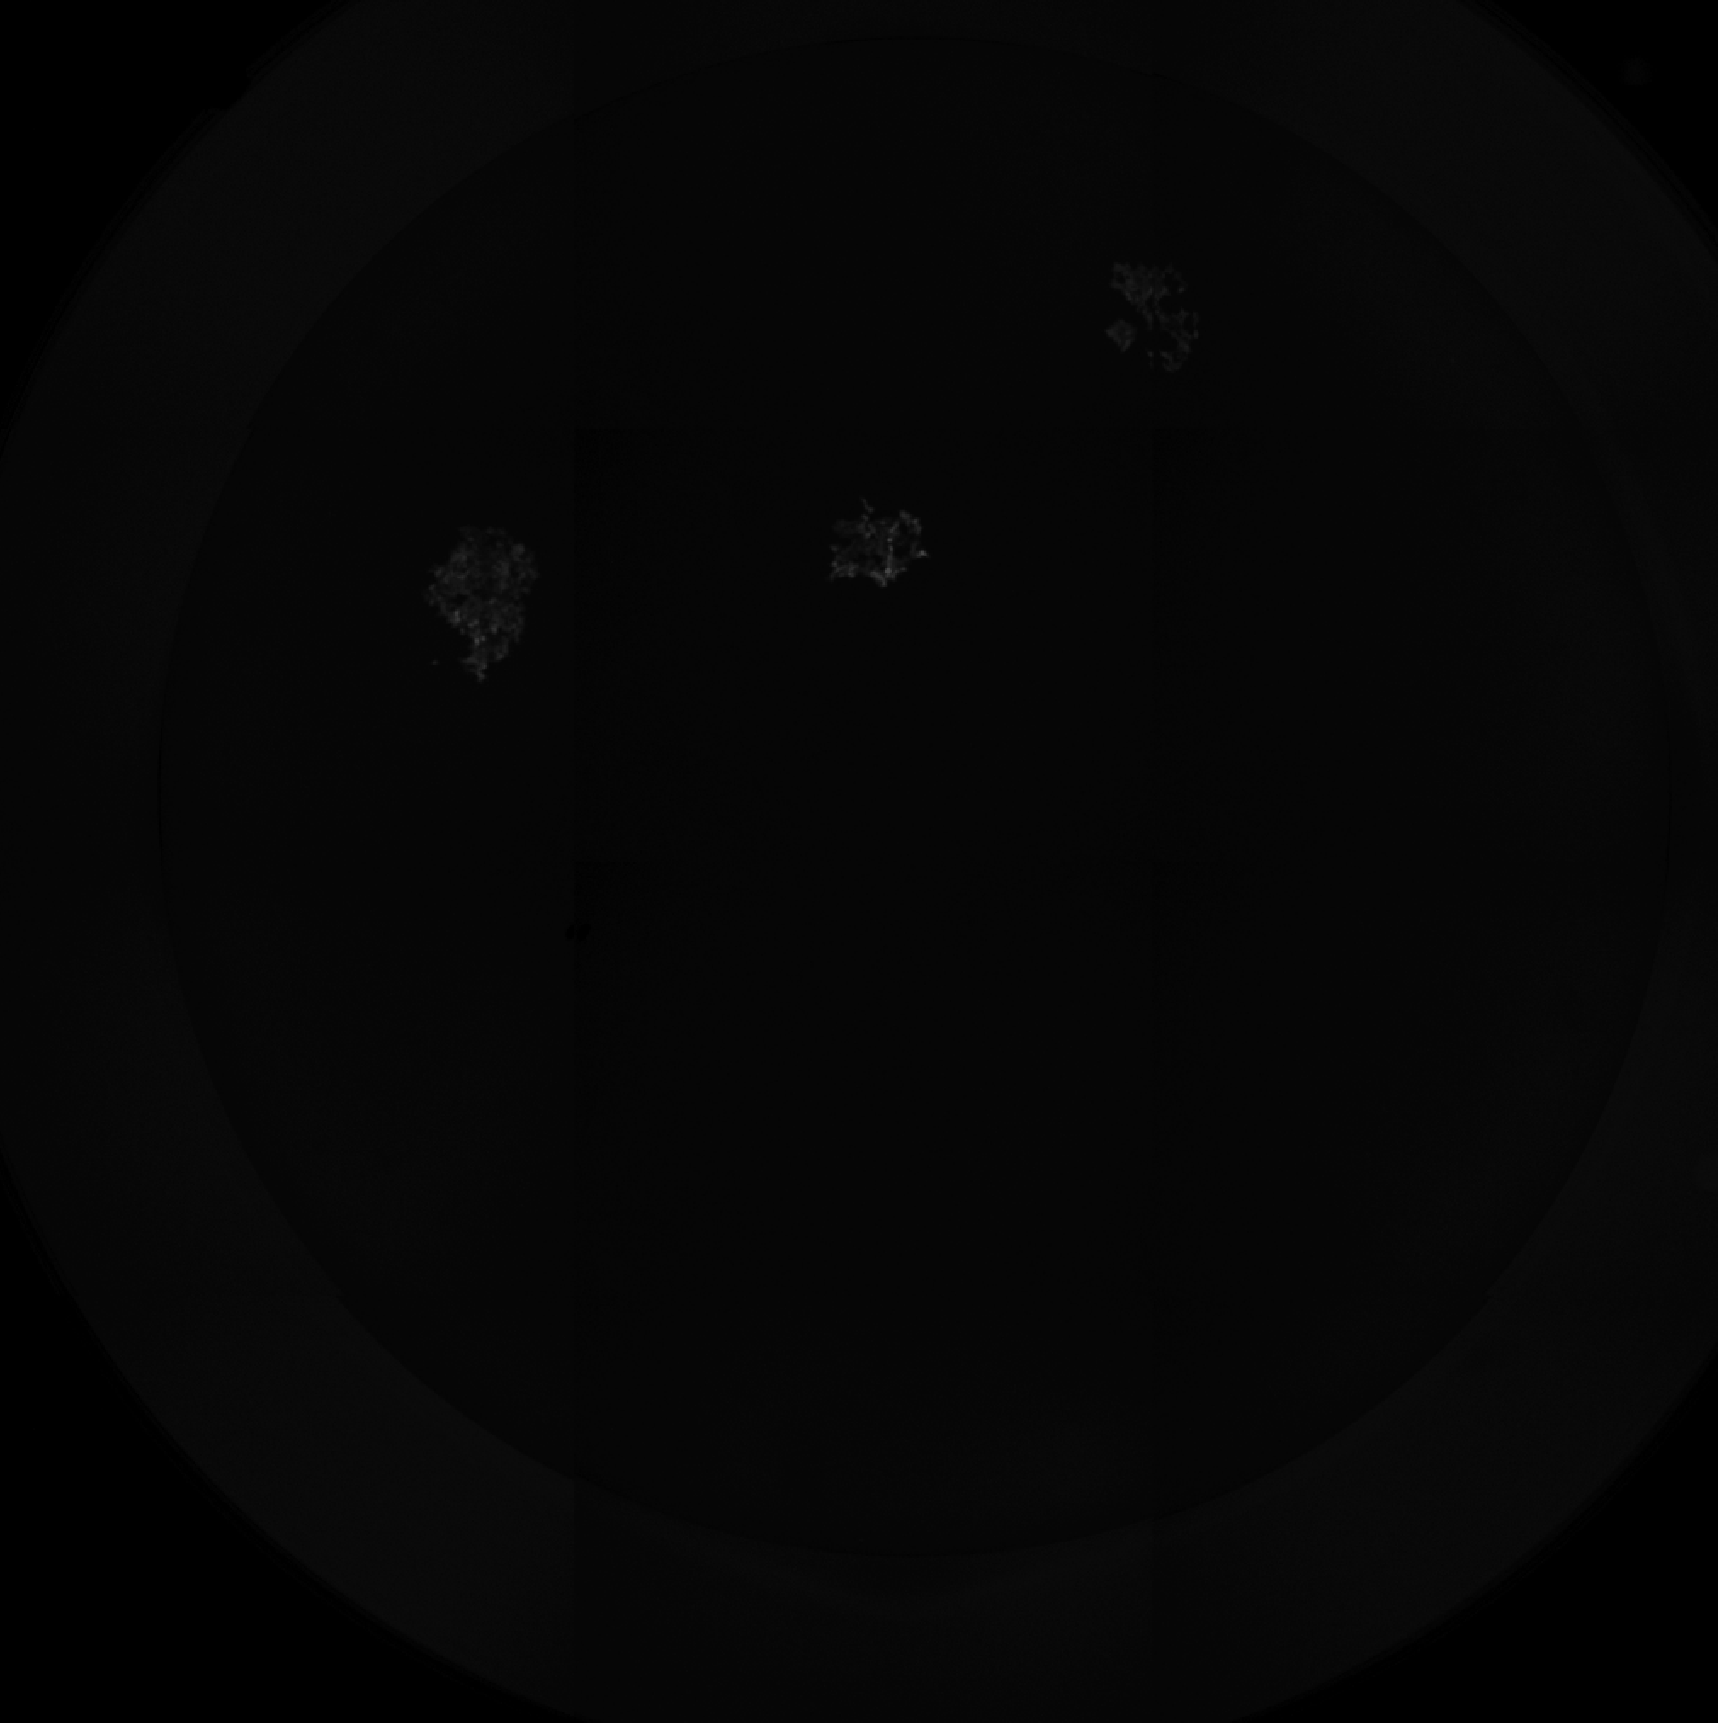

In [ ]:
#BC3, 2-3 medium clones
adata3=adata[adata.obs['Label']=='BC3',:]
bcann3=bcann[[x for x in bcann.obs.index if x in adata3.obs.index],:]
ctann3=ctann[[x for x in ctann.obs.index if x in adata3.obs.index],:]
print(adata3)
print(bcann3)
print(ctann3)
seaborn.clustermap(bcann3.X.todense())
seaborn.clustermap(ctann3.X.todense())
#sc.pl.umap(adata3,color=['Label','leiden','EpiClone','LentiClone'])

In [ ]:
import networkx as nx
m = bcann3.X * bcann3.X.T
print(m.todense())
m.setdiag(0)
m[m<2]=0
m.eliminate_zeros()
G = nx.from_scipy_sparse_matrix(m)
isos=list(nx.algorithms.isolate.isolates(G))
G.remove_nodes_from(isos)
print('G written')
nx.draw(G, with_labels=True)


In [ ]:
import matplotlib.pyplot as plt
ax = plt.axes()
seaborn.distplot(np.sum(bcann3.X,axis=1))
ax.set_title('Barcodes per cell, well 3')
plt.show()
print(np.sum(bcann3.X,axis=0).shape)
seaborn.clustermap(np.log10((bcann3.X * bcann3.X.T).todense()+1))
plt.show()
seaborn.clustermap(np.log10((ctann3.X * ctann3.X.T).todense()+1))


In [ ]:
import matplotlib.pyplot as plt
ax = plt.axes()
seaborn.distplot(np.sum(ctann3.X,axis=1))
ax.set_title('Lenti per cell, clone 3')


In [ ]:
import matplotlib.pyplot as plt
seaborn.distplot(corrs)
seaborn.distplot(randocorrs)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
ax = plt.axes()
seaborn.distplot(np.sum(ctann3.X,axis=1))
ax.set_title('Lenti per cell, clone 3')


# Collapse Barcodes
Uses starcode to cluster and collapse barcode sequence. this is necessary because sequences are relatively low quality due to repeated bases

In [ ]:
#/home/mt/code/utils/miniconda3/envs/starcode/bin/starcode -t 4 -i  -o '+outfile+' --seq-id -d '+str(levenshteinthresh)
def collapseBarcodes(inpath,levenshteinthresh=1,cellumi=False):
    import subprocess
    import pandas as pd
    import os
    indir=os.path.dirname(os.path.abspath(inpath))
    infile=os.path.basename(inpath)
    intermedfile=os.path.join(indir,'intermed_'+infile)
    bctable=pd.read_csv(inpath,sep='\t',header = 0)
    outfile=os.path.join(indir,'collapsed_'+infile)
    if cellumi:
        import re
        bctable['Cell.BC']=[re.sub("-1","",x)for x in bctable['Cell.BC']]
        (bctable['Cell.BC']+bctable['Cell.Tag']).to_csv(intermedfile,sep='\t',index=False,header=False)
        subprocess.run('/home/mt/code/utils/miniconda3/envs/starcode/bin/starcode-umi -t 4 -i '+intermedfile+' -o '+outfile+' --seq-id --umi-len 16 --umi-d 0 --seq-d '+str(levenshteinthresh),shell=True)    
    else:
        bctable['Cell.Tag'].to_csv(intermedfile,sep='\t',index=False,header=False)
        subprocess.run('/home/mt/code/utils/miniconda3/envs/starcode/bin/starcode -t 4 -i '+intermedfile+' -o '+outfile+' --seq-id -d '+str(levenshteinthresh),shell=True)


In [ ]:
collapseBarcodes("/home/mt/Downloads/well1_Out/outs/pU6_bctable.txt",2,False)

In [ ]:
import numpy as np
import seaborn
import matplotlib.pyplot as plt
collapseBarcodes("/home/mt/Downloads/well1_Out/outs/pU6_bctable.txt",0)
ctann=bcTableToAnndata("~/Downloads/well1_Out/outs/pU6_bctable.txt",correctionPath="/home/mt/Downloads/well1_Out/outs/collapsed_pU6_bctable.txt",threshold=0)
seaborn.distplot(np.log10(np.sum(ctann.X,axis=0)+1))
plt.show()
seaborn.distplot(np.log10(np.sum(ctann.X,axis=1)+1))
plt.show()
collapseBarcodes("/home/mt/Downloads/well1_Out/outs/pU6_bctable.txt",1)
ctann=bcTableToAnndata("~/Downloads/well1_Out/outs/pU6_bctable.txt",correctionPath="/home/mt/Downloads/well1_Out/outs/collapsed_pU6_bctable.txt",threshold=0)
seaborn.distplot(np.log10(np.sum(ctann.X,axis=0)+1))
plt.show()
seaborn.distplot(np.log10(np.sum(ctann.X,axis=1)+1))
plt.show()
collapseBarcodes("/home/mt/Downloads/well1_Out/outs/pU6_bctable.txt",2)
ctann=bcTableToAnndata("~/Downloads/well1_Out/outs/pU6_bctable.txt",correctionPath="/home/mt/Downloads/well1_Out/outs/collapsed_pU6_bctable.txt",threshold=0)
seaborn.distplot(np.log10(np.sum(ctann.X,axis=0)+1))
plt.show()
seaborn.distplot(np.log10(np.sum(ctann.X,axis=1)+1))
plt.show()


In [ ]:
correcttable=pd.read_csv("~/Downloads/well2_Out/outs/collapsed_pCXLE18_bcs.txt",sep='\t',header = None,index_col=False)
bctable=pd.read_csv("/home/mt/Downloads/well2_Out/outs/pCXLE18_bcs.txt",sep='\t',header = 0,index_col=False)

newtab=[]
for index,cluster in correcttable.iterrows():
    ll=[int(x) for x in cluster[2].split(',')]
    newtab.append(pd.DataFrame({'Cell.BC':bctable['Cell.BC'][ll],'Cell.Tag':np.repeat(cluster[0],len(ll))}))
bctable=pd.concat(newtab)
bctable.to_csv("/home/mt/Downloads/well2_Out/outs/pCXLE18_bctable_collapsed.txt",sep='\t',header=True)

In [ ]:
bctable.groupby('Cell.Tag')['Cell.Tag'].count()

In [ ]:
len(bctable['Cell.Tag'].unique())